# Reproducción Paper

### Paquetes

In [2]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates

/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Funciones

In [3]:
##############################
# 1. Descargar de datos GOES #
##############################

## 1.1. Descargar datos
def Download_Data(start_time, end_time, resolution="avg1m"):
    
    """
    Entrada / Input:
        start_time (str): Tiempo inicial del intervalo de búsqueda, en formato compatible con SunPy.
        end_time (str): Tiempo final del intervalo de búsqueda, en formato compatible con SunPy.
        resolution (str, opcional / optional): Resolución temporal de los datos GOES. 
            Opciones válidas: "flx1s", "avg1m". Por defecto es 'avg1m'.

    Salida / Output:
        TimeSeries: Objeto de SunPy que contiene los datos XRS del satélite GOES 
                    dentro del intervalo de tiempo especificado.
                    con la resolución especificada.

    Descripción / Description:
        Esta función busca, descarga y carga datos del instrumento GOES (X-Ray Sensor, XRS)
        en el intervalo de tiempo especificado y con la resolución deseada. Utiliza Fido para la búsqueda
        y retorna un objeto TimeSeries con los datos.

        This function searches for, downloads, and loads data from the GOES (X-Ray Sensor, XRS)
        within the specified time interval and chosen resolution. It uses Fido for querying and 
        returns a TimeSeries object with the data.
    """

    # Validar resolución / Validate resolution
    valid_resolutions = ["flx1s", "avg1m"]
    if resolution not in valid_resolutions:
        raise ValueError(f"Resolución no válida. Usa una de: {valid_resolutions}")

     # Buscar y descargar los datos de GOES / Search and download GOES data
    result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes, a.Resolution(resolution))
    archivos = Fido.fetch(result)

    # Cargar los datos en un TimeSeries / Load the data into a TimeSeries
    goes_ts = TimeSeries(archivos[0], source="XRS")
    print(goes_ts)
    goes_ts.peek()

    return goes_ts

## 1.2. Truncar datos
def Truncate_Data(goes_ts, flare_start_time, flare_end_time):
    
    """
    Entrada / Input:
        goes_ts (TimeSeries): Objeto TimeSeries con los datos GOES completos.
        flare_start_time (str): Tiempo de inicio de la fulguración (en formato compatible con SunPy).
        flare_end_time (str): Tiempo de fin de la fulguración (en formato compatible con SunPy).

    Salida / Output:
        TimeSeries: Objeto TimeSeries con los datos recortados al intervalo de la fulguración.

    Descripción / Description:
        Esta función recorta un conjunto de datos GOES a un intervalo de tiempo específico
        correspondiente al inicio y fin de una fulguración solar. Si el intervalo no contiene datos,
        se lanza una excepción.

        This function trims a GOES TimeSeries dataset to a specific time interval
        corresponding to the start and end of a solar flare. If the interval contains no data,
        an exception is raised.
    """

    # Seleccionar el rango de interés / Select the time range of interest
    goes_flare = goes_ts.truncate(flare_start_time, flare_end_time)

    # Verificar si hay datos disponibles  / Check if data is available
    if len(goes_flare.to_dataframe()) == 0:
        raise ValueError("El rango de datos seleccionado está vacío. Revisa las fechas.")
        # The selected time range is empty. Please check the input times.

    # Visualizar los datos truncados / Plot the trimmed data
    goes_flare.peek()

    return goes_flare

#################################################
# 2. Funciones de apoyo para go_GOES_background #
#################################################

## 2.1. Función para calcular los segundos desde el 2000
def count_leap_seconds_since_2000(seconds_since_base):
    
    """
    Entrada / Input:
        seconds_since_base (float): Número de segundos transcurridos desde el 1 de enero de 2000 a las 12:00 UTC.

    Salida / Output:
        int: Número de segundos intercalares (leap seconds) acumulados desde el año 2000 hasta el tiempo objetivo.

    Descripción / Description:
        Esta función calcula el número de segundos intercalares añadidos desde el 1 de enero del año 2000
        hasta una fecha objetivo especificada en segundos desde esa fecha base. Utiliza una lista actualizada
        de fechas con segundos intercalares reconocidas oficialmente.

        This function calculates the number of leap seconds added since January 1, 2000
        up to a target date specified by seconds elapsed from that base date.
        It uses an updated list of officially recognized leap second dates.

    Referencia / Reference:
        Lista actualizada de segundos intercalares / Updated leap second list:
        https://www.nist.gov/pml/time-and-frequency-division/time-realization/leap-seconds
    """

    leap_seconds_list = [
        (datetime(2000, 1, 1, 0, 0, 0), 0),   # Base time
        (datetime(2005, 12, 31, 23, 59, 59), 1),
        (datetime(2008, 12, 31, 23, 59, 59), 2),
        (datetime(2012, 6, 30, 23, 59, 59), 3),
        (datetime(2015, 6, 30, 23, 59, 59), 4),
        (datetime(2016, 12, 31, 23, 59, 59), 5),
    ]
    
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    target_time = base_time + timedelta(seconds=seconds_since_base)
    
    leap_seconds = 0
    for date, leap in leap_seconds_list:
        if target_time > date:
            leap_seconds = leap
        else:
            break
    
    return leap_seconds

## 2.2. Función que carga y lee archivos .nc (se necesita porque el archivo que contiene el backgroun es .nc)
def load_netcdf(file_path):

    """
    Entrada / Input:
        file_path (str): Ruta al archivo NetCDF que se desea cargar.

    Salida / Output:
        netCDF4.Dataset o None: Objeto Dataset con el contenido del archivo NetCDF si se carga correctamente; 
                                None en caso de error.

    Descripción / Description:
        Esta función carga un archivo NetCDF utilizando la biblioteca netCDF4. Verifica si el archivo existe,
        imprime sus dimensiones, variables y una muestra de los primeros datos de cada variable. 
        Retorna el objeto Dataset para su posterior uso.

        This function loads a NetCDF file using the netCDF4 library. It checks if the file exists,
        prints its dimensions, variables, and a sample of the first values of each variable.
        Returns the Dataset object for further use.
    """

    if not os.path.exists(file_path):
        print(f"Error: El archivo {file_path} no existe.")
        return
    
    try:
        dataset = nc.Dataset(file_path, mode='r')
        print("Contenido del archivo NetCDF:")
        print("Dimensiones:")
        for dim in dataset.dimensions:
            print(f"  {dim}: {len(dataset.dimensions[dim])}")
        
        print("\nVariables:")
        for var in dataset.variables:
            print(f"  {var}: {dataset.variables[var].dimensions} - {dataset.variables[var].shape}")
        
        print("\nPrimeros datos de cada variable:")
        for var in dataset.variables:
            try:
                data = dataset.variables[var][:5]  # Muestra los primeros 5 valores si es posible
                print(f"  {var}: {data}")
            except Exception as e:
                print(f"  No se pueden mostrar datos de {var}: {e}")

        return dataset  # Retorna el dataset para su uso en otras funciones
    except Exception as e:
        print(f"Error al cargar el archivo NetCDF: {e}")
        return None

## 2.3. Función para convertir los datos en un DataFrame de pandas
def netcdf_to_dataframe(dataset):
    
    """
    Entrada / Input:
        dataset (netCDF4.Dataset): Objeto NetCDF cargado previamente con netCDF4.

    Salida / Output:
        pandas.DataFrame o None: DataFrame con las variables del archivo NetCDF si la conversión es exitosa;
                                 None en caso de error.

    Descripción / Description:
        Esta función convierte todas las variables contenidas en un archivo NetCDF a un DataFrame de pandas,
        siempre que todas las variables sean compatibles en tamaño. Es útil para analizar y visualizar datos
        tabulares derivados de archivos NetCDF.

        This function converts all variables from a NetCDF file into a pandas DataFrame,
        as long as the variables are compatible in shape. It is useful for analyzing and visualizing
        tabular data from NetCDF files.
    """
    
    if dataset is None:
        print("Error: No hay un dataset cargado.")
        return None
    
    try:
        data_dict = {}
        for var in dataset.variables:
            data_dict[var] = dataset.variables[var][:]
        print("Conversión de DataFrame de pandas")
        df = pd.DataFrame(data_dict)
        return df
    except Exception as e:
        print(f"Error al convertir NetCDF a DataFrame: {e}")
        return None

## 2.4. Función para convertir segundos a fecha 
def seconds_to_datetime(seconds_since_base, include_leap_seconds=False):
    """
    Entrada / Input:
        seconds_since_base (float): Número de segundos transcurridos desde el 1 de enero de 2000 a las 12:00 UTC.
        include_leap_seconds (bool): Si es True, incluye los segundos intercalares en el cálculo.

    Salida / Output:
        str: Fecha y hora en formato UTC correspondiente al número de segundos especificado.

    Descripción / Description:
        Esta función convierte un número de segundos desde la época base (1 de enero de 2000, 12:00 UTC)
        a una fecha y hora en formato UTC. Puede opcionalmente incluir los segundos intercalares
        en el cálculo.

        This function converts a number of seconds since the base epoch (January 1, 2000, 12:00 UTC)
        into a UTC datetime string. It can optionally include leap seconds in the computation.
    """
    
    # Definir la época base: 2000-01-01 12:00:00 UTC
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    
    # Calcular los segundos intercalares si se incluyen
    leap_seconds = 0
    if include_leap_seconds:
        leap_seconds = count_leap_seconds_since_2000(seconds_since_base)
    
    # Sumar los segundos transcurridos + segundos intercalares
    result_time = base_time + timedelta(seconds=seconds_since_base + leap_seconds)
    
    return result_time.strftime('%Y-%m-%d %H:%M:%S UTC')

## 2.5. Función para convertir fecha a segundos
def datetime_to_seconds(date_str, include_leap_seconds=False):

    """
    Entrada / Input:
        date_str (str): Fecha y hora en formato 'YYYY-MM-DD HH:MM:SS'.
        include_leap_seconds (bool): Si es True, descuenta los segundos intercalares acumulados.

    Salida / Output:
        int: Número de segundos transcurridos desde el 1 de enero de 2000 a las 12:00 UTC.

    Descripción / Description:
        Esta función convierte una fecha y hora en formato de cadena a un número entero de segundos 
        transcurridos desde la época base (1 de enero de 2000 a las 12:00 UTC). Si se especifica, 
        se restan los segundos intercalares acumulados hasta esa fecha para reflejar el tiempo UTC ajustado.

        This function converts a datetime string into the number of seconds elapsed since the base epoch 
        (January 1, 2000 at 12:00 UTC). If specified, accumulated leap seconds are subtracted from the result 
        to reflect adjusted UTC time.
    """


    # Definir la época base: 2000-01-01 12:00:00 UTC
    base_time = datetime(2000, 1, 1, 12, 0, 0)
    
    # Convertir la fecha de entrada a un objeto datetime
    target_time = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    
    # Calcular la diferencia en segundos
    seconds_since_base = int((target_time - base_time).total_seconds())
    
    # Restar los segundos intercalares si se incluyen
    leap_seconds = 0
    if include_leap_seconds:
        leap_seconds = count_leap_seconds_since_2000(seconds_since_base)
        seconds_since_base -= leap_seconds
    
    return seconds_since_base

## 2.6. Función para obtener valores de un tiempo específico
def get_value_by_time(df, time_value, variable_name):
    
    """
    Entrada / Input:
        df (pandas.DataFrame): DataFrame que contiene una columna de tiempo y variables asociadas.
        time_value (any): Valor del tiempo que se desea buscar (debe coincidir exactamente con la columna 'time').
        variable_name (str): Nombre de la variable cuyo valor se desea extraer.

    Salida / Output:
        any: Valor de la variable en el instante de tiempo especificado, o None si no se encuentra.

    Descripción / Description:
        Esta función busca en un DataFrame el valor de una variable específica correspondiente a un tiempo exacto.
        Si el tiempo o la variable no existen, devuelve None y muestra un mensaje de error.

        This function searches in a DataFrame for the value of a specific variable corresponding to an exact time.
        If the time or variable does not exist, it returns None and prints an error message.
    """
    
    if df is None:
        print("Error: No hay un DataFrame cargado.")
        return None
    
    if variable_name not in df.columns:
        print(f"Error: La variable '{variable_name}' no existe en el DataFrame.")
        return None
    
    try:
        result = df.loc[df['time'] == time_value, variable_name]
        return result.values[0] if not result.empty else None
    except Exception as e:
        print(f"Error al obtener el valor para el tiempo {time_value}: {e}")
        return None

############################
# 3. Métodos de Background #
############################

## 3.1. Background calculado por GOES - solo para GOES 16, 17 y 18
def go_GOES_background (file_path, start_time, end_time):

    """
    Entrada / Input:
        file_path (str): Ruta del archivo NetCDF con datos de background de GOES.
        start_time (str): Tiempo inicial del intervalo de interés (formato: 'YYYY-MM-DD HH:MM:SS').
        end_time (str): Tiempo final del intervalo de interés (formato: 'YYYY-MM-DD HH:MM:SS').

    Salida / Output:
        tuple: Valores de background para los canales XRS-A y XRS-B (value_a, value_b).

    Descripción / Description:
        Esta función carga un archivo NetCDF con datos de nivel de fondo (background) de GOES,
        convierte el tiempo de observación a segundos desde la época base (1 enero 2000 12:00:00 UTC),
        filtra los datos para el intervalo deseado y extrae los valores de background para los canales XRS-A y XRS-B.

        This function loads a NetCDF file containing GOES background flux data,
        converts the observation time to seconds since the reference epoch (Jan 1, 2000, 12:00:00 UTC),
        filters the data for the specified time range, and returns the background values
        for the XRS-A and XRS-B channels.

    Notas adicionales / Additional notes:
        - Se consideran segundos intercalares (leap seconds) en las conversiones de tiempo.
        - La resolución temporal es diaria (un valor de background por día).
    
    Segundo a datatime
        según datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/docs/GOES-R_XRS_L2_Data_Users_Guide.pdf

        background
        donde encontrar los datos de backgroun de GOES 16, 17 y 18: https://www.ncei.noaa.gov/products/goes-r-extreme-ultraviolet-xray-irradiance

        datos de background: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-bkd1d_science/


        # Restar el background y aplicar factor de conversión
        # https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)
    
    """
    # Función que carga y lee el archivo donde se encuentran los datos de background de GOES del 2017 al 2025:
    dataset = load_netcdf(file_path)
    if dataset:
        print("El archivo se cargó correctamente.")
        print("Variables disponibles:", dataset.variables.keys())
        print("Primeros valores de 'time':", dataset.variables['time'][:5])
        
    if not os.path.exists(file_path):
        print(f"Error: El archivo en '{file_path}' no existe.")
    else:
        print(f"El archivo existe en: {file_path}")
    
    #background_level=0
    print("Ahora convertimos a pandas:")
    df = netcdf_to_dataframe(dataset)
    print(df)
    
    # Calcula la diferencia entre tiempos consecutivos
    df['time_diff'] = df['time'].diff()

    time_difference = df['time'].iloc[1] - df['time'].iloc[0]
    print("Diferencia entre el segundo y el primer elemento:", time_difference, "segundos")


    # Muestra los valores únicos de la diferencia de tiempo
    print(df['time_diff'].unique())

    # También puedes obtener la resolución más común
    print("Resolución temporal más frecuente:", df['time_diff'].mode()[0], "segundos")

    #Resolución temporal en minutos
    time_difference_minutes = time_difference / 60
    print("Diferencia en minutos:", time_difference_minutes, "minutos")

    #Resolución temporal en horas
    time_difference_hours = time_difference / 3600
    print("Diferencia en horas:", time_difference_hours, "horas")

    #Resolución temporal en días
    time_difference_days = time_difference / 86400
    print("Diferencia en días:", time_difference_days, "días")

    # Funciones para calcular el tiempo en segundos para extraer el background:
    ## no tengo un valor de background para cada tiempo porque solo tengo un valor de background por día
    ## entonces se mira en el intervalo del día cual valor se asigna
    start_date = start_time
    end_date = end_time
    
    date_string = start_time
    time_in_seconds = datetime_to_seconds(date_string, include_leap_seconds=True)
    #Comprobar que el # de segundos si corresponde a la fecha estudiada
    date = seconds_to_datetime(time_in_seconds, include_leap_seconds=True)
    print("Fecha del flare:", {date_string}, "En segundos:", {time_in_seconds}, "comprobar fecha:", {date})

    
    t_inicio = datetime_to_seconds(start_date, include_leap_seconds=True)
    t_fin = datetime_to_seconds(end_date, include_leap_seconds=True)
    print('tiempo inicio:', start_date, 'corresponde a:', t_inicio, 'segundos')
    print('tiempo final:', end_date, 'corresponde a:', t_fin, 'segundos')
    
    # Filtrar el DataFrame según el intervalo del día del flare
    df_filtrado = df[(df['time'] >= t_inicio) & (df['time'] <= t_fin)]

    # Imprimir el resultado
    print(df_filtrado)

    valor_time = df_filtrado['time'].values[0]
    print("Tiempo en segundos del que extraeremos el valor de background",{valor_time})

    # Función para obtener valores de un tiempo específico
    time_value= valor_time
    variable_name = "bkd1d_xrsa_flux"  # Cambia esto por la variable que deseas consultar
    value_a = get_value_by_time(df, time_value, variable_name)
    if value_a is not None:
        print(f"Valor de {variable_name} en {time_value}: {value_a}")

    variable_name = "bkd1d_xrsb_flux"  # Cambia esto por la variable que deseas consultar
    value_b = get_value_by_time(df, time_value, variable_name)
    if value_b is not None:
        print(f"Valor de {variable_name} en {time_value}: {value_b}")

    return value_a, value_b   

## 3.2. calcular background como el valor mínimo en los 10 min anteriores a la fulguración
def go_min_time_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10):
    
    """
    Entrada / Input:
        goes_flare (TimeSeries): Objeto TimeSeries con los datos recortados a la fulguración.
        flare_start_time (str o datetime): Tiempo estimado de inicio de la fulguración.
        channel (str): Canal GOES a analizar ('xrsa' o 'xrsb'). Por defecto es 'xrsa'.
        window_minutes (int): Ventana de tiempo en minutos posterior al inicio para estimar el nivel de fondo.
                              Por defecto es 10 minutos.

    Salida / Output:
        float: Nivel de fondo (mínimo flujo) estimado en el canal seleccionado, previo al inicio de la fulguración.

    Descripción / Description:
        Esta función estima el nivel de fondo de una fulguración solar utilizando datos del satélite GOES.
        Busca el flujo mínimo dentro de una ventana de tiempo definida tras el inicio de la fulguración, 
        y genera una gráfica que muestra el flujo, el nivel de fondo y el inicio estimado de la fulguración.

        This function estimates the background level of a solar flare using GOES satellite data.
        It finds the minimum flux within a time window after the flare start and plots the flux,
        background level, and estimated flare start time.
    """
    
    # convertimos el tipo de tiempo (flare_start_time) de string a datetime.strptime
    # Convert string to datetime if needed
    
    if isinstance(flare_start_time, str):
        flare_start_time = datetime.strptime(flare_start_time, "%Y-%m-%d %H:%M:%S")

    # tiempo final de observación para calcular el background = tiempo inicial del flare + 10 min
    # Definir el tiempo final de la ventana para el cálculo del fondo
    # Define end of background window
    window_finish =  flare_start_time + timedelta(minutes=window_minutes) #flare_start_time + 10 min
    flux = goes_flare.data[channel]
    background_level = np.min(flux[flare_start_time:window_finish])

    print(f'Valor de background banda {channel}: {background_level}')

    # --- GRAFICAR ---

    time_delta1 =  flare_start_time + timedelta(seconds=6) #flare_start_time + 6 seg
    time_delta2 =  flare_start_time - timedelta(seconds=6) #flare_start_time - 6 seg

    flare_start_index = flare_start_time

    time = goes_flare.data.index

    flare_start_index = np.argwhere((time>time_delta2) & (time<time_delta1))[0][0]
    print(f'valor de flare_start_index: {flare_start_index}')
        


    plt.figure(figsize=(10, 5))
    plt.plot(time, flux, label=f'Flujo de rayos X ({channel})', color='blue')
    plt.axhline(background_level, color='red', linestyle='--', label='Nivel de fondo estimado')
    plt.axvline(time[flare_start_index], color='green', linestyle='--', label='Inicio estimado de fulguración')
    plt.xlabel('Tiempo')
    plt.ylabel('Flujo de rayos X [W/m²]')
    plt.title(f'Estimación del nivel de fondo previo a la fulguración- canal: {channel}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return background_level

## 3.3. Calcular background como la media, moda, mínimo o percentil
def go_sta_Background(goes_flare, method='median', scaling_factor_a=0.85, scaling_factor_b=0.7):
    """
    Entrada / Input:
        goes_flare: Objeto SunPy TimeSeries con datos GOES.
        method (str): Método para calcular el background. Opciones:
                      'median', 'mode', 'min', 'percentile_X' (ej. 'percentile_10').

    Salida / Output:
        background_a (float): Nivel de background para canal XRSA (0.5–4 Å).
        background_b (float): Nivel de background para canal XRSB (1–8 Å).

    Descripción / Description:
        Calcula el nivel de background para ambos canales GOES de un flare usando el método especificado.
        Returns background levels without modifying the original data.

    Notas / Notes:
        - 'percentile_X' debe usar un número entre 0 y 100, por ejemplo 'percentile_25'.
        - En caso de error con la moda, se usa la mediana como respaldo.
    """

    df = goes_flare.to_dataframe()

    def compute_background(flux, method):
        if method == 'median':
            return flux.median()
        elif method == 'mode':
            mode_val = flux.mode()
            return mode_val.iloc[0] if not mode_val.empty else flux.median()
        elif method == 'min':
            return flux.min()
        elif method.startswith('percentile_'):
            try:
                perc = float(method.split('_')[1])
                return flux.quantile(perc / 100)
            except (IndexError, ValueError):
                raise ValueError("Formato incorrecto para método 'percentile_X'. Usa por ejemplo 'percentile_10'.")
        else:
            raise ValueError(f"Método no reconocido: {method}")

    background_a = compute_background(df["xrsa"], method)
    background_b = compute_background(df["xrsb"], method)

    return background_a, background_b

## 3.4. Función que calcula las diferencias de flujos de 5 min
def running_difference (goes_ts, start_time, end_time, plot=False):

    """
    Entrada / Input:
        goes_ts: Objeto TimeSeries de SunPy con datos de rayos X blandos (XRSA) y duros (XRSB).
        start_time (str): Tiempo inicial para mostrar en la gráfica (formato 'YYYY-MM-DD HH:MM:SS').
        end_time (str): Tiempo final para mostrar en la gráfica (formato 'YYYY-MM-DD HH:MM:SS').
        plot (bool): Si es True, muestra la gráfica de flujos y diferencias.

    Salida / Output:
        goes_flare_corrected_diff: Objeto TimeSeries con las diferencias temporales (running difference)
        aplicadas a los canales XRSA y XRSB.

    Descripción / Description:
        Esta función calcula la diferencia temporal (running difference) en el flujo de rayos X
        observados por el satélite GOES, utilizando un desplazamiento fijo de tiempo. Las diferencias
        se grafican junto con el flujo original para visualizar cambios súbitos en la emisión.

        This function computes the running difference in soft X-ray flux observed by the GOES satellite,
        using a fixed time shift. The resulting differences are plotted alongside the original fluxes to
        highlight sudden changes in emission.

    Notas / Notes:
        - La diferencia temporal se calcula con un desplazamiento de 5 puntos.
        - El gráfico incluye tanto los flujos originales como sus diferencias.
        - El objeto original no se modifica; se devuelve una copia con los datos modificados.
        - Útil para detectar picos o aumentos abruptos de emisión durante fulguraciones solares.
    """

    #  Extraer los datos de rayos X blandos y duros
    df = goes_ts.to_dataframe()
    flux_xrsb = df["xrsb"]  # Canal 1-8 Å (rayos X blandos)
    flux_xrsa = df["xrsa"]  # Canal 0.5-4 Å (rayos X duros)
    print(flux_xrsa)

    # se define un valor de desplazamiento temporal de 5 puntos 
    fai_dt = 5 #5 el delta para las diferencias 

    # npts almacena el número de elementos en la variable fluxa
    npts = len(flux_xrsa)
    print(npts)

    # Se calcula la diferencia entre valores de fluxa separados por fai_dt pasos.
    #fluxa[fai_dt:] selecciona los valores desde el índice fai_dt (5) hasta el final
    #fluxa[:npts-fai_dt] selecciona los valores desde el índice 1 hasta npts-fai_dt.
    #La resta representa el cambio en el flujo a lo largo de fai_dt (5) pasos en fluxa
    diffa = np.array(flux_xrsa[fai_dt:]) - np.array(flux_xrsa[:npts - fai_dt])
    #La resta representa el cambio en el flujo a lo largo de fai_dt (5) pasos en fluxb
    diffb = np.array(flux_xrsb[fai_dt:]) - np.array(flux_xrsb[:npts - fai_dt])

    print(len(diffa))
    
    ##### Gráfica ####
    if plot:
        # Crear la figura
        plt.figure(figsize=(6, 5))

        # Definir los límites de tiempo
        limite_inferior = pd.Timestamp(start_time) 
        limite_superior = pd.Timestamp(end_time)

        # Aplicar los límites en el eje X
        plt.xlim(limite_inferior, limite_superior)
        # Graficar flux_xrsa y flux_xrsb
        plt.plot(df.index, flux_xrsa, label="Flux XRSA (0.5-4 Å)", color='red')
        plt.plot(df.index, flux_xrsb, label="Flux XRSB (1-8 Å)", color='blue')

        # Crear un eje de tiempo para diffa y diffb (ajustado por fai_dt)
        time_diff = df.index[fai_dt:]

        # Graficar diffa y diffb
        plt.plot(time_diff, diffa, label="ΔFlux XRSA", linestyle="dashed", color='darkred')
        plt.plot(time_diff, diffb, label="ΔFlux XRSB", linestyle="dashed", color='darkblue')

        # Etiquetas y título
        plt.xlabel("Time")
        plt.ylabel("Flux (W/m²)")
        plt.title("Flux and Change in X-ray Flux")
        plt.legend()

        # Formato del eje X
        plt.xticks(rotation=45)

        # Mostrar la gráfica
        plt.tight_layout()
        plt.show()

        ##### end gráfica ###

    #  Asignar los datos corregidos al TimeSeries
    goes_flare_corrected_diff = copy.deepcopy(goes_ts)

    diffa_full = np.zeros(npts)
    diffb_full = np.zeros(npts)

    diffa_full[fai_dt:] = diffa
    diffb_full[fai_dt:] = diffb

    goes_flare_corrected_diff.data["xrsb"] = diffb_full
    goes_flare_corrected_diff.data["xrsa"] = diffa_full


    return goes_flare_corrected_diff

##########################
# 4. Resta de Background #
##########################

## 4.1. Restar el background y aplicar factor de conversión en caso de método 'goes_file'
# https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)
# NO se aplica factor de conversión a GOES: 16, 17, 18 ->scaling_factor_a=1, scaling_factor_b=1

def remove_goes_background(goes_flare, method='stat', 
                           flare_start_time=None, 
                           file_path=None, 
                           start_time=None, 
                           end_time=None,
                           stat_method='median',
                           scaling_factor_a=1,
                           scaling_factor_b=1,
                           plot=False):
    """
    Entrada / Input:
        goes_flare (TimeSeries): Objeto SunPy TimeSeries con datos de fulguración.
        method (str): Método para procesar el background o calcular diferencias. Opciones:
                      - 'stat': cálculo estadístico (median, mode, min, percentile_X).
                      - 'min10': mínimo en los 10 min posteriores al inicio del flare.
                      - 'goes_file': lectura del valor de background desde archivo NetCDF.
                      - 'diff5': llama a la función externa running_difference().
        flare_start_time (str o datetime): Tiempo estimado de inicio del flare (necesario para 'min10').
        file_path (str): Ruta al archivo NetCDF (necesario para 'goes_file').
        start_time (str): Inicio del intervalo de interés (necesario para 'diff5' y 'goes_file').
        end_time (str): Fin del intervalo de interés (necesario para 'diff5' y 'goes_file').
        stat_method (str): Método estadístico para 'stat' (ej: 'median', 'percentile_25').
        scaling_factor_a=1, scaling_factor_b=1: factor de conversión (scaling_factor)
            # NO se aplica factor de conversión a GOES: 16, 17, 18 ->scaling_factor_a=1, scaling_factor_b=1
        plot (bool): Si es True, pasa plot=True a running_difference o muestra gráfica de corrección.

    Salida / Output:
        goes_flare_corrected (TimeSeries): Objeto corregido o con diferencias temporales según método.

    Descripción / Description:
        Esta función permite aplicar distintos métodos para remover el background de un flare GOES o 
        calcular la diferencia temporal en los flujos. El resultado puede visualizarse si se desea.

    Notas / Notes:
        - Si se usa 'diff5', se llama a la función `running_difference`.
        - Los valores negativos se recortan a cero excepto en 'diff5'.
    """

    # === Método especial: diferencia de flujo a 5 minutos ===
    if method == 'diff5':
        if not start_time or not end_time:
            raise ValueError("Para 'diff5' debes proporcionar 'start_time' y 'end_time'.")
        return running_difference(goes_flare, start_time, end_time)

    # === Métodos de background (stat, min10, goes_file) ===
    if method == 'stat':
        background_a, background_b = go_sta_Background(goes_flare, method=stat_method)

    elif method == 'min10':
        if flare_start_time is None:
            raise ValueError("Debes proporcionar 'flare_start_time' para el método 'min10'")
        background_a = go_min_time_background(goes_flare, flare_start_time, channel='xrsa')
        background_b = go_min_time_background(goes_flare, flare_start_time, channel='xrsb')

    elif method == 'goes_file':
        if not all([file_path, start_time, end_time]):
            raise ValueError("Debes proporcionar 'file_path', 'start_time' y 'end_time' para el método 'goes_file'")
        background_a, background_b = go_GOES_background(file_path, start_time, end_time)

    else:
        raise ValueError(f"Método de background no reconocido: {method}")

    # === Corregir ===
    df = goes_flare.to_dataframe().copy()
    print(f'Extraer los datos de rayos X blandos y duros:')
    flux_xrsa = df["xrsa"]  # Canal 0.5-4 Å (rayos X - canal corto)
    flux_xrsb = df["xrsb"]  # Canal 1-8 Å (rayos X - canal blandos)

    df["xrsa_clean"] = ((flux_xrsa - background_a)*scaling_factor_a).clip(lower=0) #/1.42
    df["xrsb_clean"] = ((flux_xrsb - background_b)*scaling_factor_b).clip(lower=0) #corrección en la banda larga (1-8 A)

    # Copia de los datos del flare (goes_flare) para no modificar los originales
    goes_flare_corrected = copy.deepcopy(goes_flare)
    print(f'imprimir Copia de los datos del flare (goes_flare) para no modificar los originales')
    print(goes_flare_corrected)

    # Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas
    print(f'Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas')
    same_index = goes_flare_corrected.data.index.equals(df.index)
    print(f'goes_flare_corrected y df tienen los mismos índices: {same_index}')

    # imprimimos los primeros datos de df y goes_flare_corrected para ver los indices
    print(df["xrsb_clean"].head())
    print(goes_flare_corrected.data.index[:5])

    # imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected
    print(f'imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected')
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    # reemplazamos los datos en la columa y verificamos que si copiaron
    print(f'reemplazamos los datos en la columa y verificamos que si copiaron')
    goes_flare_corrected.data["xrsa"] = df["xrsa_clean"]
    goes_flare_corrected.data["xrsb"] = df["xrsb_clean"]
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    print(f'imprimir goes corregidos:')
    print(goes_flare_corrected)

    #df["xrsa"] = ((df["xrsa"] - background_a)* scaling_factor_a).clip(lower=0)
    #df["xrsb"] = ((df["xrsb"] - background_b)* scaling_factor_b).clip(lower=0)
    #goes_flare_corrected = TimeSeries(df, meta=goes_flare.meta, concatenated=True)

    # === Gráfica si se solicita ===
    if plot:
        time = goes_flare.data.index
        fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

        axs[0].plot(time, goes_flare.data["xrsa"], label="Original XRSA", color='blue', alpha=0.6)
        axs[0].plot(time, df["xrsa_clean"], label="Corregido XRSA", color='red')
        axs[0].set_ylabel("Flujo XRSA [W/m²]")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(time, goes_flare.data["xrsb"], label="Original XRSB", color='green', alpha=0.6)
        axs[1].plot(time, df["xrsb_clean"], label="Corregido XRSB", color='orange')
        axs[1].set_ylabel("Flujo XRSB [W/m²]")
        axs[1].set_xlabel("Tiempo")
        axs[1].legend()
        axs[1].grid(True)

        fig.suptitle("Comparación GOES original vs corregido (background)", fontsize=14)
        plt.tight_layout()
        plt.show()

    return goes_flare_corrected

#####################################
# 5. Temperatura y Emission Measure #
#####################################

## 5.1. Calcular la Temperatura y Medida de emisión con los datos corregidos
#Calculate_Tem_EM(goes_flare_corrected, abundance='photospheric')
#Calculate_Tem_EM(goes_flare_corrected, abundance='coronal')
def Calculate_Tem_EM(goes_flare_corrected, abundance='coronal'):
    
    """
    Entrada / Input:
        goes_flare_corrected: Objeto TimeSeries corregido que contiene los datos del flare solar en los
        canales XRSA y XRSB. Debe ser compatible con la función `calculate_temperature_em` de SunPy.
        abundance (str): Tipo de abundancia elemental a usar en el cálculo (por defecto: 'coronal').
                         Otras opciones posibles incluyen 'photospheric', dependiendo del modelo de SunPy.

    Salida / Output:
        temp_em: Objeto que contiene la temperatura (T) y medida de emisión (EM) derivadas a partir de los
        datos GOES corregidos.

    Descripción / Description:
        Esta función utiliza los datos corregidos del satélite GOES para calcular la temperatura del plasma
        y la medida de emisión (EM) durante un evento de fulguración solar. Permite especificar el modelo
        de abundancia elemental a utilizar en el cálculo.

        This function uses corrected GOES data to compute the plasma temperature and emission measure (EM)
        during a solar flare. It allows specifying the elemental abundance model to be used in the calculation.

    Notas / Notes:
        - Usa la función `calculate_temperature_em` de SunPy.
        - El parámetro `abundance` controla el modelo de abundancias (por ejemplo, 'coronal' o 'photospheric').
        - Se desactiva temporalmente la verificación del hash de calibración del instrumento.
        - Los datos deben estar previamente corregidos y limpios.
    """

    print(f'Ahora vamos a calcular la T y EM con el modelo de abundancias:{abundance}')
    #  Saltar la verificación del hash temporalmente
    with manager.skip_hash_check():
        #temp_em = calculate_temperature_em(goes_flare_corrected, abundance='coronal')
        temp_em = calculate_temperature_em(goes_flare_corrected, abundance)
    
    print(f'se calculó T y EM con el modelo de abundancias:{abundance}')
    print(temp_em)
    return temp_em

## 5.2. Graficar un modelo 
def Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, 
                  title, method_name, integration_time,
                  T_min=5, T_max=30, EM_min=1e46, EM_max=1e50,
                  umbral_temp_max=30, colorear_por_tiempo=True):
    """
    Entrada / Input:
        goes_flare_corrected: TimeSeries con datos GOES corregidos.
        temp_em: TimeSeries con temperatura y medida de emisión calculadas.
        time_colors: Tiempo límite para el cambio de color (formato: 'YYYY-MM-DD HH:MM:SS').
        title: Título del gráfico.
        T_min, T_max: Límites del eje Y para la temperatura (en MK).
        EM_min, EM_max: Límites del eje X para la medida de emisión (en cm⁻³).
        umbral_temp_max: Umbral máximo de temperatura para filtrar datos (en MK).
        colorear_por_tiempo (bool): Si True, colorea los puntos según el tiempo. Si False, usa color uniforme.

    Salida / Output:
        None (muestra el gráfico).

    Descripción / Description:
        Esta función grafica los valores de temperatura y medida de emisión durante una fulguración solar,
        con la opción de colorear los puntos en función del tiempo transcurrido desde el inicio o graficarlos
        todos del mismo color.

        This function plots the temperature and emission measure values during a solar flare, allowing the
        user to choose between coloring the points by time progression or using a single color.

    Notas / Notes:
        - Usa escala logarítmica para el eje de emisión.
        - Aplica un filtro por temperatura máxima (umbral).
        - El gráfico incluye una barra de colores solo si `colorear_por_tiempo=True`.
    """

    # Convertir a DataFrame y alinear
    df_temp_em = temp_em.to_dataframe()
    df_flare = goes_flare_corrected.to_dataframe()
    df_merged = df_temp_em.join(df_flare, how='inner')

    # Extraer y convertir datos
    temperatura = df_merged["temperature"].to_numpy() * u.K
    medida_em = df_merged["emission_measure"].to_numpy() * u.cm**(-3)
    tiempo_datetime = df_merged.index
    inicio = tiempo_datetime[0]
    tiempo_segundos = (tiempo_datetime - inicio).total_seconds()

    # Filtrar por umbral de temperatura
    filtro = temperatura < (umbral_temp_max * u.MK)
    temperatura_filtrada = temperatura[filtro]
    medida_em_filtrada = medida_em[filtro]
    tiempo_segundos_filtrado = tiempo_segundos[filtro]

    # Crear figura
    plt.figure(figsize=(5, 4))

    if colorear_por_tiempo:
        # Límite para colorear
        limite_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")
        limite_tiempo = (limite_dt - inicio).total_seconds()
        mascara_coloreados = tiempo_segundos_filtrado <= limite_tiempo
        mascara_grises = tiempo_segundos_filtrado > limite_tiempo

        # Puntos coloreados
        sc = plt.scatter(medida_em_filtrada[mascara_coloreados],
                         temperatura_filtrada[mascara_coloreados],
                         c=tiempo_segundos_filtrado[mascara_coloreados],
                         cmap='viridis', marker='+', edgecolors='none',
                         linewidth=1.0, s=30)

        # Puntos grises
        plt.scatter(medida_em_filtrada[mascara_grises],
                    temperatura_filtrada[mascara_grises],
                    color='gray', s=5, marker='.', edgecolor='none')

        # Barra de color
        cbar = plt.colorbar(sc)
        cbar.set_label("Time since start (seconds)")
    else:
        # Todos los puntos en negro
        plt.scatter(medida_em_filtrada,
                    temperatura_filtrada,
                    color='black', s=10, marker='x', edgecolor='none')

    # Ajustes del gráfico
    plt.xscale("log")
    plt.xlim(EM_min, EM_max)
    plt.ylim(T_min, T_max)
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(rf"Flare: {title} - Method: {method_name}, Integration time={integration_time}")
    #plt.title(title)
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return None

## 5.3. Graficar los dos modelos
def Graphics_T_EM_Cor_Phot(goes_flare_corrected, temp_em_diff_Cor, temp_em_diff_Phot, title,
                           T_min=5, T_max=30, EM_min=1e46, EM_max=1e50, umbral_temp_max=30):
    
    """
    Entrada / Input:
        goes_flare_corrected : TimeSeries
            Serie temporal con datos GOES corregidos (background restado), usada como referencia temporal.
        temp_em_diff_Cor : TimeSeries
            Serie temporal con temperatura y medida de emisión calculadas usando abundancia **coronal**.
        temp_em_diff_Phot : TimeSeries
            Serie temporal con temperatura y medida de emisión calculadas usando abundancia **fotosférica**.
        title : str
            Título del gráfico.
        T_min : float, opcional (default=5)
            Límite inferior para la temperatura (en MK) en el eje Y del gráfico.
        T_max : float, opcional (default=30)
            Límite superior para la temperatura (en MK) en el eje Y del gráfico.
        EM_min : float, opcional (default=1e46)
            Límite inferior para la medida de emisión (en cm⁻³) en el eje X del gráfico (escala logarítmica).
        EM_max : float, opcional (default=1e50)
            Límite superior para la medida de emisión (en cm⁻³) en el eje X del gráfico (escala logarítmica).
        umbral_temp_max : float, opcional (default=30)
            Umbral máximo de temperatura (en MK) para filtrar los puntos a graficar.

    Salida / Output:
        None (la función muestra un gráfico matplotlib).

    Descripción / Description:
        Esta función grafica la evolución térmica de una fulguración solar bajo dos modelos de abundancia:
        **coronal** y **fotosférico**, usando datos GOES corregidos. Se comparan las distribuciones de temperatura
        y medida de emisión (EM) para ambos modelos.

        Los datos se filtran por un umbral superior de temperatura para evitar valores atípicos o saturaciones
        instrumentales. Se grafican los puntos de cada modelo con diferentes colores y marcadores:

        - Modelo **coronal**: puntos rojos (`o`)
        - Modelo **fotosférico**: puntos azules (`^`)

        El eje X (EM) se muestra en escala logarítmica. El gráfico incluye leyenda, rejilla y ajustes de límites
        personalizables.

    Notas / Notes:
        - Es útil para comparar visualmente cómo afecta la elección del modelo de abundancia (coronal vs fotosférico)
          en las estimaciones de temperatura y medida de emisión.
        - La función imprime detalles del número de puntos y rangos antes y después del filtrado por temperatura.
    """

    # ---- Modelo Coronal ----
    df_Cor = temp_em_diff_Cor.to_dataframe().join(goes_flare_corrected.to_dataframe(), how='inner')
    T_Cor = df_Cor["temperature"].to_numpy()        # en MK
    EM_Cor = df_Cor["emission_measure"].to_numpy()  # en 1/cm³

    print("Modelo Coronal:")
    print("Temperatura (total):", len(T_Cor))
    print("EM (total):", len(EM_Cor))

    filtro_Cor = T_Cor < umbral_temp_max
    T_Cor = T_Cor[filtro_Cor]
    EM_Cor = EM_Cor[filtro_Cor]

    # ---- Modelo Fotosférico ----
    df_Phot = temp_em_diff_Phot.to_dataframe().join(goes_flare_corrected.to_dataframe(), how='inner')
    T_Phot = df_Phot["temperature"].to_numpy()      # en MK
    EM_Phot = df_Phot["emission_measure"].to_numpy()# en 1/cm³

    print("Modelo Fotosférico:")
    print("Temperatura (total):", len(T_Phot))
    print("EM (total):", len(EM_Phot))

    filtro_Phot = T_Phot < umbral_temp_max
    T_Phot = T_Phot[filtro_Phot]
    EM_Phot = EM_Phot[filtro_Phot]

    # ---- Comprobación filtro ----

    print("Después del filtro Coronal:", len(T_Cor), len(EM_Cor))
    print("Después del filtro Fotosférico:", len(T_Phot), len(EM_Phot))

    print("Modelo Coronal:")
    print("T min:", T_Cor.min(), "T max:", T_Cor.max())
    print("EM min:", EM_Cor.min(), "EM max:", EM_Cor.max())

    print("Modelo Fotosférico:")
    print("T min:", T_Phot.min(), "T max:", T_Phot.max())
    print("EM min:", EM_Phot.min(), "EM max:", EM_Phot.max())

    # ---- Gráfica ----
    plt.figure(figsize=(6, 5))
    plt.xscale("log")

    # Conectar puntos con líneas (en orden)
    #plt.plot(EM_Cor, T_Cor, color='red', linewidth=1, alpha=0.5, label='Línea Coronal')
    #plt.plot(EM_Phot, T_Phot, color='blue', linewidth=1, alpha=0.5, label='Línea Fotosférico')

    # También marcar los puntos
    plt.scatter(EM_Cor, T_Cor, color='red', marker='o', s=10, label='Coronal')
    plt.scatter(EM_Phot, T_Phot, color='blue', marker='^', s=10, label='Photospheric')


    #plt.xlim(EM_min, EM_max)
    #plt.ylim(T_min, T_max)

    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

###############################
# 6. Flare Anticipation Index #
###############################

## 6.1. FAI segun modelos
def compute_fai_events(temp_em_ts, model="Coronal", delta_t=5, em_thresh=0.005, Tmin=7, Tmax=14, fai_dur=3):
    """
    Entrada / Input:
        temp_em_ts: Objeto TimeSeries con temperatura y medida de emisión del modelo (coronal o fotosférico).
        model (str): Etiqueta para identificar el modelo en el registro (por ejemplo, "Coronal", "Photosferic").
        delta_t (int): Número de minutos para calcular la diferencia temporal.
        em_thresh (float): Umbral de diferencia en EM (en unidades de 1e49 cm⁻³) para considerar un evento FAI.
        Tmin (float): Temperatura mínima (en MK) para considerar un evento.
        Tmax (float): Temperatura máxima (en MK) para considerar un evento.
        fai_dur (int): Duración mínima entre eventos (en minutos) para que se consideren eventos separados.

    Salida / Output:
        fai_event_times (list of pd.Timestamp): Lista de marcas de tiempo donde se detectaron eventos FAI.

    Descripción / Description:
        Esta función detecta eventos FAI (Flux-Anomaly Increase) a partir de una serie temporal de medidas de emisión
        y temperatura. Utiliza un método de diferencia temporal para encontrar incrementos significativos en la EM
        dentro de un rango de temperatura definido, y agrupa los eventos cercanos en el tiempo.

        This function detects FAI (Flux-Anomaly Increase) events from a time series of emission measure and temperature.
        It uses a temporal difference method to find significant EM increases within a defined temperature range,
        and groups temporally close events.

    Notas / Notes:
        - La EM se normaliza dividiéndola por 1e49 para trabajar con unidades prácticas.
        - Se aplica un filtro de temperatura y se descartan diferencias nulas.
        - Solo se registra un nuevo evento si ocurre al menos `fai_dur` minutos después del anterior.
    """

    df_em = temp_em_ts.to_dataframe()
    df_em_resampled = df_em.resample("1min").mean()   # agrupa los datos por intervalos de tiempo de 1 minuto - calculando el promedio dentro de cada intervalo
    em = df_em_resampled["emission_measure"] / 1e49
    df_em_resampled["em_diff"] = em - em.shift(periods=delta_t)

    # Filtros
    mask_T = df_em_resampled["temperature"].between(Tmin, Tmax)
    mask_diff = df_em_resampled["em_diff"].notna()
    df_em_filt = df_em_resampled[mask_T & mask_diff]

    # Eventos FAI preliminares
    fai_times = df_em_filt[df_em_filt["em_diff"] > em_thresh].index - pd.Timedelta(minutes=delta_t)

    # Agrupación
    fai_event_times = []
    for t in fai_times:
        if not fai_event_times or (t - fai_event_times[-1]) > pd.Timedelta(f"{fai_dur}min"):
            fai_event_times.append(t)

    print(f"FAI events ({model}):", fai_event_times)
    return fai_event_times

## 6.2. Grafica de FAI segun modelos
def plot_goes_with_fai_models(goes_ts, temp_em_cor=None, temp_em_phot=None,
                               method_name="Diff 5 min",
                               integration_time="1 min",
                               delta_t=5,
                               em_thresh=0.005,
                               Tmin=7, Tmax=14,
                               fai_dur=3,
                               flux_min=1e-9, flux_max=1e-4,
                               models_to_plot="both"):
    """
    Entrada / Input:
        goes_ts: Objeto TimeSeries de SunPy con datos de rayos X blandos (XRSA) y duros (XRSB).
        temp_em_cor: Objeto TimeSeries con temperatura y emisión medida para el modelo coronal.
        temp_em_phot: Objeto TimeSeries con temperatura y emisión medida para el modelo fotosférico.
        method_name: Nombre del método de detección FAI (por defecto "Diff 5 min").
        integration_time: Tiempo de integración usado en el cálculo (por defecto "1 min").
        delta_t: Desplazamiento temporal en minutos para el cálculo de diferencias.
        em_thresh: Umbral mínimo de diferencia en emisión medida para considerar un evento FAI.
        Tmin, Tmax: Rango de temperatura (en MK) para filtrar eventos FAI.
        fai_dur: Duración mínima entre eventos FAI consecutivos (en minutos).
        flux_min, flux_max: Límites del eje Y (flujo GOES) en el gráfico (W/m²).
        models_to_plot: Modelo(s) a graficar: "coronal", "photospheric" o "both".

    Salida / Output:
        fai_events_cor: Lista de tiempos de eventos FAI detectados en el modelo coronal.
        fai_events_phot: Lista de tiempos de eventos FAI detectados en el modelo fotosférico.

    Descripción / Description:
        Esta función calcula y grafica los eventos FAI detectados a partir de curvas de
        temperatura y emisión medida asociadas a uno o dos modelos (coronal y/o fotosférico),
        sobre un gráfico de flujo de rayos X GOES en escala logarítmica.

        This function computes and plots FAI events detected from time series of temperature
        and emission measure associated with one or both models (coronal and/or photospheric),
        over a log-scale plot of GOES soft X-ray flux.

    Notas / Notes:
        - La detección FAI se basa en un umbral de diferencia normalizada de emisión medida.
        - Los eventos se muestran como líneas verticales (coronal en rojo, fotosférico en azul).
        - Se puede usar solo un modelo si se desea.
        - Útil para comparar detecciones FAI entre diferentes modelos atmosféricos.
    """

    fai_events_cor, fai_events_phot = [], []

    if models_to_plot in ["both", "coronal"] and temp_em_cor is not None:
        fai_events_cor = compute_fai_events(temp_em_cor, "Coronal", delta_t, em_thresh, Tmin, Tmax, fai_dur)

    if models_to_plot in ["both", "photospheric"] and temp_em_phot is not None:
        fai_events_phot = compute_fai_events(temp_em_phot, "Photospheric", delta_t, em_thresh, Tmin, Tmax, fai_dur)

    df_goes = goes_ts.to_dataframe()
    fluxa = df_goes["xrsa"]
    fluxb = df_goes["xrsb"]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.semilogy(fluxa.index, fluxa, label="GOES 0.5–4 Å")
    ax.semilogy(fluxb.index, fluxb, label="GOES 1–8 Å")

    for t in fai_events_cor:
        ax.axvline(t, color='red', linestyle='-', alpha=0.6, label='Coronal FAI' if t == fai_events_cor[0] else "")
    for t in fai_events_phot:
        ax.axvline(t, color='blue', linestyle='--', alpha=0.6, label='Photospheric FAI' if t == fai_events_phot[0] else "")

    ax.set_xlabel("Time")
    ax.set_ylabel("X-ray Flux (W/m²)")
    ax.set_ylim(flux_min, flux_max)
    ax.set_title(rf"FAI: {method_name} (Integration time={integration_time}, Δt={delta_t} min, Δem={em_thresh}, T=[{Tmin},{Tmax}]MK, FAI duration={fai_dur} min)")
    ax.legend(loc="upper right")
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Formato eje X
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 10)))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    ax.tick_params(axis='x', which='minor', length=4, color='gray')
    ax.tick_params(axis='x', which='major', length=6)

    start_time = fluxa.index[0].strftime('%d-%b-%y %H:%M:%S')
    ax.set_xlabel(f"Start Time ({start_time})", fontsize=10)
    plt.tight_layout()
    plt.show()

    return fai_events_cor, fai_events_phot

#######################
# 7. Descargar Flares #
#######################

## 7.1. Descarga de datos de flares
def get_flares(start_time, end_time):
      
    # Buscar fulguraciones solares del 2024
    resultado = Fido.search(a.Time(start_time, end_time), a.hek.FL)
    
    # Descargar los datos
    table = resultado[0].to_pandas()
    print("Ahora imprime la tabla")
    print(table)
    # Seleccionar columnas relevantes
    flare_data = table[["event_starttime", "fl_goescls", "obs_observatory", "event_peaktime"]]
    print("Ahora imprime la tabla datos ")
    print(table)
    flare_data.columns = ["Date", "Class", "Observatory", "event_peaktime"]
    
    return flare_data
    
######################################
# 8. Tiempo de Anticipacion de flare #
######################################

## 8.1 Anticipation time
def anticipation_fai_time(goes_ts, fai_times, flares_df, peak_time_column="Peak_Time", show_all=False, show_plot=True):
    """
    Entrada / Input:
        goes_ts: Objeto TimeSeries de SunPy con datos de rayos X (XRSA y XRSB).
        fai_times (list of datetime): Tiempos de ocurrencia de eventos FAI.
        flares_df (pd.DataFrame): Tabla con datos de fulguraciones, incluyendo la hora pico.
        peak_time_column (str): Nombre de la columna con la hora pico del flare (por defecto 'Peak_Time').
        show_all (bool): Si True, muestra todos los eventos; si False, solo aquellos con anticipación válida.
        show_plot (bool): Si True, muestra un gráfico con las curvas GOES y los eventos FAI/flare.

    Salida / Output:
        flares_df (pd.DataFrame): Mismo DataFrame con columnas añadidas:
            - 'Anticipation (min)': Tiempo en minutos entre el FAI previo y el flare.
            - 'Previous FAI': Timestamp del FAI más cercano antes del flare.

    Descripción / Description:
        Esta función calcula cuánto tiempo antes de cada fulguración se detectó el FAI más cercano,
        y visualiza esta relación sobre los datos de flujo X-ray GOES. Es útil para analizar
        el valor predictivo de los eventos FAI respecto a las fulguraciones solares.

        This function computes how long before each flare the nearest prior FAI occurred, and optionally
        plots this relationship on top of GOES X-ray flux data. It is useful for assessing the predictive
        relevance of FAI events relative to solar flares.

    Notas / Notes:
        - Los FAIs deben ser anteriores a los picos de flare para que se consideren anticipaciones válidas.
        - Si no se proporciona goes_ts, solo se calcula la tabla sin generar gráfica.
        - La función anota los tiempos de anticipación sobre la curva de luz para visualización.
    """
    flares_df = flares_df.copy()
    flares_df[peak_time_column] = pd.to_datetime(flares_df[peak_time_column])

    anticipation_minutes = []
    used_fai = []

    for peak_time in flares_df[peak_time_column]:
        previous_fais = [t for t in fai_times if t < peak_time]
        if previous_fais:
            nearest_fai = max(previous_fais)
            anticipation = (peak_time - nearest_fai).total_seconds() / 60.0
            anticipation_minutes.append(anticipation)
            used_fai.append(nearest_fai)
        else:
            anticipation_minutes.append(None)
            used_fai.append(None)

    flares_df["Anticipation (min)"] = anticipation_minutes
    flares_df["Previous FAI"] = used_fai

    if not show_all:
        flares_df = flares_df[flares_df["Anticipation (min)"].notna()]

    if show_plot:
        if goes_ts is not None:
            df_goes = goes_ts.to_dataframe()
            fluxa = df_goes["xrsa"]
            fluxb = df_goes["xrsb"]

            fig, ax = plt.subplots(figsize=(10, 4))
            ax.semilogy(fluxa.index, fluxa, label="GOES 0.5–4 Å")
            ax.semilogy(fluxb.index, fluxb, label="GOES 1–8 Å")
            ax.set_ylabel("X-ray Flux [W/m²]")

            ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 60, 10)))
            plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
            ax.tick_params(axis='x', which='minor', length=4, color='gray')
            ax.tick_params(axis='x', which='major', length=6)

            if not flares_df.empty:
                plt.vlines(flares_df[peak_time_column], ymin=0, ymax=1, color='blue', linestyle='--', label='Flare Peak')
                plt.vlines(flares_df["Previous FAI"].dropna(), ymin=0, ymax=1, color='red', label='Previous FAI')

                for _, row in flares_df.iterrows():
                    if pd.notna(row["Previous FAI"]):
                        plt.annotate(f"{row['Anticipation (min)']:.1f} min",
                                     xy=(row["Previous FAI"], 0.9),
                                     xytext=(row["Previous FAI"], 1.05),
                                     rotation=90, fontsize=8, color='blue', ha='center')

                plt.title("FAI Anticipation of Solar Flares")
                plt.xlabel("Time")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
        else:
            print("No GOES time series provided for plotting.")

    return flares_df


### Función completa

In [4]:
def Calculate_all(start_time,
                  end_time,
                  flare_start_time,
                  flare_end_time,
                  time_colors,
                  title,
                  resolution="avg1m", # "flx1s", "avg1m"
                  file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc",
                  method='goes_file',
                  scaling_factor_a=1,
                  scaling_factor_b=1,
                  plot=True,
                  umbral_temp_max = 30,
                  delta_t=5,
                  em_thresh=0.005,
                  Tmin=7,
                  Tmax=14, 
                  fai_dur=3,
                  models_to_plot_fai="both"):
    
    # 1.1 Download_data
    # Descargar datos con resolución de {resolution}
    goes_ts = Download_Data (start_time, end_time, resolution)

    # 1.2 Truncate_Data
    # Truncar datos al tiempo del flare
    goes_flare = Truncate_Data (goes_ts, flare_start_time, flare_end_time)

    # 4. Resta de background según el método elegido
    goes_flare_corrected = remove_goes_background(goes_flare, method=method, 
                                                flare_start_time = flare_start_time, 
                                                file_path = file_path, 
                                                start_time = start_time, 
                                                end_time = end_time,
                                                scaling_factor_a=scaling_factor_a,
                                                scaling_factor_b=scaling_factor_b,
                                                plot=plot)

    # 5. Calcular T y EM con las dos abundancias coronal y fotosférico
    temp_em_cor = Calculate_Tem_EM (goes_flare_corrected, abundance='coronal')
    temp_em_phot = Calculate_Tem_EM (goes_flare_corrected, abundance='photospheric')

    # 5.2 Gráficas T vs EM de cor
    Graphics_T_EM (goes_flare_corrected, 
                   temp_em_cor, 
                   time_colors, 
                   title, 
                   method_name="coronal", 
                   integration_time=resolution,
                   T_min=None, 
                   T_max=None, 
                   EM_min=None, 
                   EM_max=None, 
                   umbral_temp_max = umbral_temp_max,
                   colorear_por_tiempo=True)

    # 5.2 Gráficas T vs EM de phot
    Graphics_T_EM (goes_flare_corrected, 
                   temp_em_phot, 
                   time_colors, 
                   title, 
                   method_name="photosferic", 
                   integration_time=resolution,
                   T_min=None, 
                   T_max=None, 
                   EM_min=None, 
                   EM_max=None, 
                   umbral_temp_max = umbral_temp_max,
                   colorear_por_tiempo=True)

    # 5.3 Comparación de Método Coronal y Fotosférico - T vs EM
    Graphics_T_EM_Cor_Phot (goes_flare_corrected,
                            temp_em_cor, 
                            temp_em_phot, 
                            title,
                            T_min=None, 
                            T_max=None, 
                            EM_min=None, 
                            EM_max=None, 
                            umbral_temp_max = umbral_temp_max,)

    # 6. Flare Anticipation Index
    # 6.1. Compute_fai_events Coronal
    compute_fai_events (temp_em_cor, model="Coronal", 
                        delta_t=delta_t,
                        em_thresh=em_thresh, 
                        Tmin=Tmin,
                        Tmax=Tmax, 
                        fai_dur=fai_dur)
    # 6.1. Compute_fai_events Photosferic
    compute_fai_events (temp_em_phot, model="Photosferic", 
                        delta_t=delta_t,
                        em_thresh=em_thresh, 
                        Tmin=Tmin,
                        Tmax=Tmax, 
                        fai_dur=fai_dur)
    
    # 6.2 Calculo y plt de FAI según el modelo que se quiera
    plot_goes_with_fai_models (goes_flare, 
                                temp_em_cor=temp_em_cor, 
                                temp_em_phot=temp_em_phot, 
                                method_name=method, 
                                integration_time=resolution, 
                                delta_t=delta_t, 
                                em_thresh=em_thresh, 
                                Tmin=Tmin, 
                                Tmax=Tmax, 
                                fai_dur=fai_dur, 
                                flux_min=None, 
                                flux_max=None, 
                                models_to_plot=models_to_plot_fai)


    return None

## Flare 2: SOL2024-02-25


#### 1.0 Flare Date

In [5]:
#  Definir el día de la fulguración

start_time = "2024-02-25 00:00:00"
end_time = "2024-02-25 23:59:00"

In [6]:
# Definir tiempo de flare
flare_start_time = "2024-02-25 14:30:00"
flare_end_time = "2024-02-25 20:30:00"
time_colors = "2024-02-25 19:00:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2024-02-25"

In [7]:
result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes)
print(result)

Results from 1 Provider:

4 Results from the XRSClient:
Source: <8: https://umbra.nascom.nasa.gov/goes/fits 
8-15: https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/science/ 
16-17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        ... Resolution SatelliteNumber
----------------------- ----------------------- ... ---------- ---------------
2024-02-25 00:00:00.000 2024-02-25 23:59:59.999 ...      flx1s              16
2024-02-25 00:00:00.000 2024-02-25 23:59:59.999 ...      avg1m              16
2024-02-25 00:00:00.000 2024-02-25 23:59:59.999 ...      flx1s              18
2024-02-25 00:00:00.000 2024-02-25 23:59:59.999 ...      avg1m              18




### Función completa Method Background = 'goes_file' Resolution = 1 min

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.77file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-02-25 00:00:00
End Date:			2024-02-25 23:59:00
Center Date:			2024-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.27E-06<br>xrsb           1.97E-05<br>xrsa_quality   2.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-02-25 00:00:00  5.740141e-08  0.000002             0             0
2024-02-25 00:01:00  7.020226e-08  0.000002             0             0
2024-02-25 00:02:00  8.091072e-08  0.000002             0             0
2024-02-25 00:03:00  9.033434e-08  0.000002             0             0
2024-02-25 00:04:00  9.776895e-08  0.000002             0             0
...                           ...       ...   

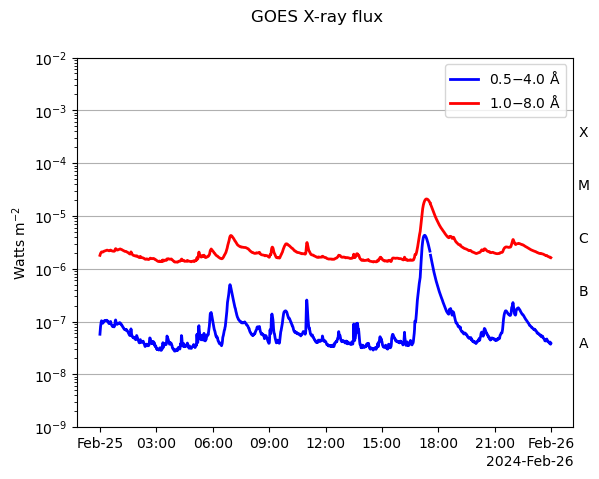

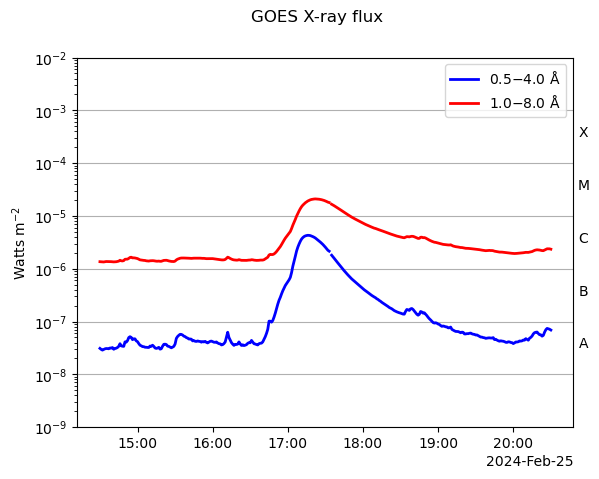

2025-05-30 02:38:41 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:38:41 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:38:41 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:38:41 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Contenido del archivo NetCDF:
Dimensiones:
  time: 2958

Variables:
  bkd1d_xrsa_flux: ('time',) - (2958,)
  bkd1d_xrsb_flux: ('time',) - (2958,)
  bkd1d_xrsa_flag: ('time',) - (2958,)
  bkd1d_xrsb_flag: ('time',) - (2958,)
  time: ('time',) - (2958,)
  avg1d_xrsa_flux: ('time',) - (2958,)
  avg1d_xrsb_flux: ('time',) - (2958,)
  avg1d_xrsa_flag: ('time',) - (2958,)
  avg1d_xrsb_flag: ('time',) - (2958,)
  avg1d_xrsa_coverage: ('time',) - (2958,)
  avg1d_xrsb_coverage: ('time',) - (2958,)

Primeros datos de cada variable:
  bkd1d_xrsa_flux: [9.9999997e-10 9.9999997e-10 1.4346336e-09 1.0083738e-09 1.0066282e-09]
  bkd1d_xrsb_flux: [3.1270432e-08 2.2764999e-08 5.1835080e-08 3.0297024e-08 3.5479687e-08]
  bkd1d_xrsa_flag: [0 0 0 0 0]
  bkd1d_xrsb_flag: [0 0 0 0 0]
  time: [5.396976e+08 5.397840e+08 5.398704e+08 5.399568e+08 5.400432e+08]
  avg1d_xrsa_flux: [7.8882305e-09 7.3544348e-09 1.5705494e-08 5.7307172e-09 3.6434877e-09]
  avg1d_xrsb_flux: [4.8892282e-08 3.4541127e-08 1.6955074e-07 

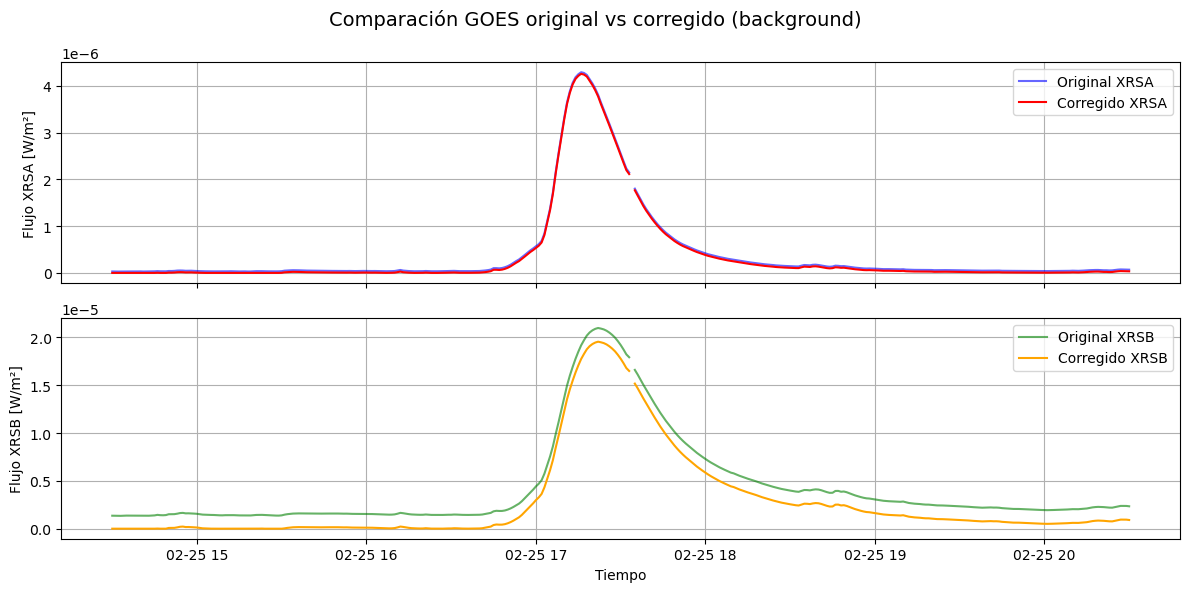

2025-05-30 02:38:42 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.21file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-05-30 02:38:44 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.59E+01<br>emission_measure   7.98E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.811526      0.000000e+00
2024-02-25 14:31:00     2.811526      0.000000e+00
2024-02-25 14:32:00     2.811526      0.000000e+00
2024-02-25 14:33:00     2.811526      0.000000e+00
2024-02-25 14:34:00     2.811526      0.000000e+00
...                          ...               ...
2024-02-25 20:26:00     6.603005      1.010214e+48
2024-02-25 20:27:00     6.732587      1.028759e+48
2024-02-25 20:28:00     6.623599      1.069629e+48
2024-02-25 20:29:00     6.561446      1.084986e+48
2024-02-25 

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.24file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.65E+01<br>emission_measure   2.05E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.637235      0.000000e+00
2024-02-25 14:31:00     2.637235      0.000000e+00
2024-02-25 14:32:00     2.637235      0.000000e+00
2024-02-25 14:33:00     2.637235      0.000000e+00
2024-02-25 14:34:00     2.637235      0.000000e+00
...                          ...               ...
2024-02-25 20:26:00     5.795107      3.537507e+48
2024-02-25 20:27:00     5.911545      3.572924e+48
2024-02-25 20:28:00     5.813598      3.740660e+48
2024-02-25 20:29:00     5.757805      3.809413e+48
2024-0

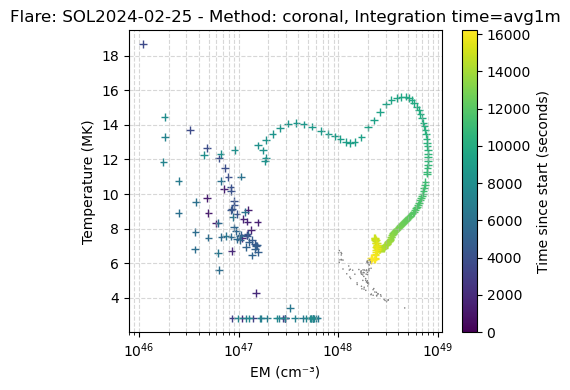

/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


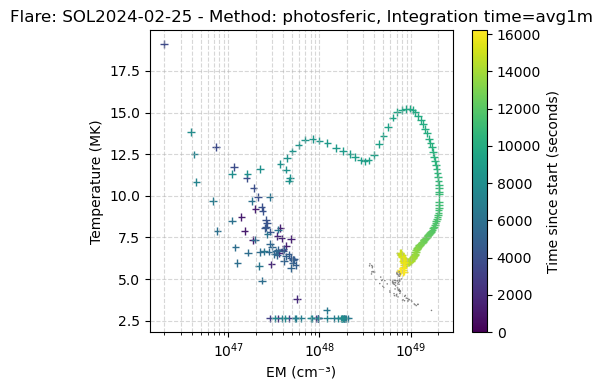

Modelo Coronal:
Temperatura (total): 361
EM (total): 361
Modelo Fotosférico:
Temperatura (total): 361
EM (total): 361
Después del filtro Coronal: 360 360
Después del filtro Fotosférico: 360 360
Modelo Coronal:
T min: 2.811525924575948 T max: 18.674978665099044
EM min: 0.0 EM max: 7.978698705689472e+48
Modelo Fotosférico:
T min: 2.637235335313468 T max: 19.11514700727159
EM min: 0.0 EM max: 2.054071068260828e+49


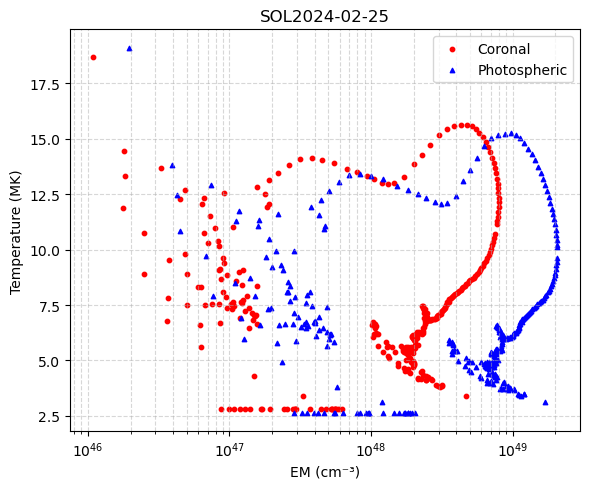

FAI events (Coronal): [Timestamp('2024-02-25 14:48:00'), Timestamp('2024-02-25 14:52:00'), Timestamp('2024-02-25 15:29:00'), Timestamp('2024-02-25 15:42:00'), Timestamp('2024-02-25 16:08:00'), Timestamp('2024-02-25 16:41:00'), Timestamp('2024-02-25 16:45:00'), Timestamp('2024-02-25 16:50:00'), Timestamp('2024-02-25 16:54:00'), Timestamp('2024-02-25 16:58:00'), Timestamp('2024-02-25 17:15:00'), Timestamp('2024-02-25 17:19:00'), Timestamp('2024-02-25 17:23:00'), Timestamp('2024-02-25 18:35:00')]
FAI events (Photosferic): [Timestamp('2024-02-25 14:45:00'), Timestamp('2024-02-25 14:49:00'), Timestamp('2024-02-25 14:53:00'), Timestamp('2024-02-25 15:27:00'), Timestamp('2024-02-25 15:31:00'), Timestamp('2024-02-25 15:35:00'), Timestamp('2024-02-25 16:06:00'), Timestamp('2024-02-25 16:41:00'), Timestamp('2024-02-25 16:45:00'), Timestamp('2024-02-25 16:49:00'), Timestamp('2024-02-25 16:53:00'), Timestamp('2024-02-25 16:57:00'), Timestamp('2024-02-25 17:13:00'), Timestamp('2024-02-25 17:17:00')

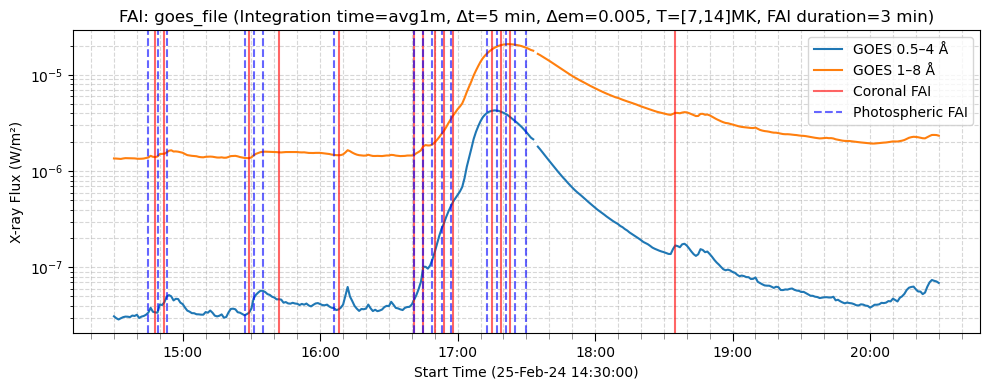

In [8]:
Calculate_all(start_time = start_time,
                  end_time = end_time,
                  flare_start_time = flare_start_time,
                  flare_end_time = flare_end_time,
                  time_colors = time_colors,
                  title = title,
                  resolution="avg1m",
                  file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc",
                  method='goes_file',
                  scaling_factor_a=1,
                  scaling_factor_b=1,
                  plot=True,
                  umbral_temp_max = 30,
                  delta_t=5,
                  em_thresh=0.005,
                  Tmin=7,
                  Tmax=14, 
                  fai_dur=3,
                  models_to_plot_fai="both")

### Función completa Method Background = 'diff5' Resolution = 1 min

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  4.01file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-02-25 00:00:00
End Date:			2024-02-25 23:59:00
Center Date:			2024-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.27E-06<br>xrsb           1.97E-05<br>xrsa_quality   2.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-02-25 00:00:00  5.740141e-08  0.000002             0             0
2024-02-25 00:01:00  7.020226e-08  0.000002             0             0
2024-02-25 00:02:00  8.091072e-08  0.000002             0             0
2024-02-25 00:03:00  9.033434e-08  0.000002             0             0
2024-02-25 00:04:00  9.776895e-08  0.000002             0             0
...                           ...       ...   

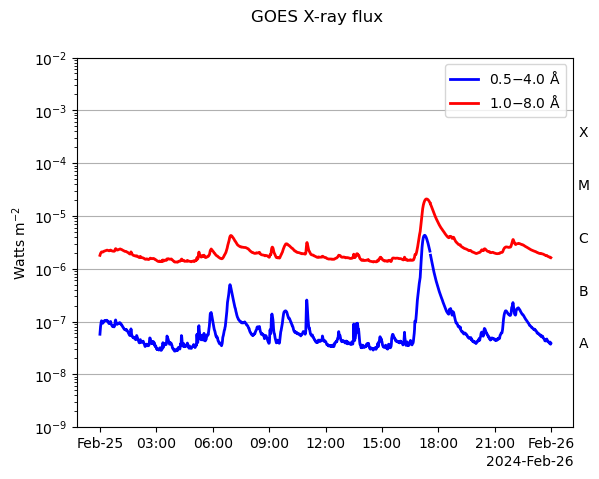

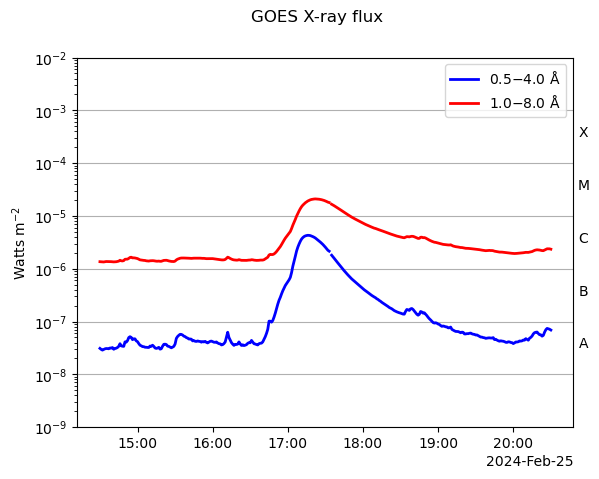

2025-05-30 02:38:57 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:38:57 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


2024-02-25 14:30:00    3.098842e-08
2024-02-25 14:31:00    2.963028e-08
2024-02-25 14:32:00    2.873944e-08
2024-02-25 14:33:00    2.959969e-08
2024-02-25 14:34:00    3.038569e-08
                           ...     
2024-02-25 20:26:00    6.994622e-08
2024-02-25 20:27:00    7.399005e-08
2024-02-25 20:28:00    7.254669e-08
2024-02-25 20:29:00    7.142041e-08
2024-02-25 20:30:00    6.896057e-08
Name: xrsa, Length: 361, dtype: float32
361
356
Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.25file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-05-30 02:38:58 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.69E+01<br>emission_measure   1.26E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.811526      0.000000e+00
2024-02-25 14:31:00     2.811526      0.000000e+00
2024-02-25 14:32:00     2.811526      0.000000e+00
2024-02-25 14:33:00     2.811526      0.000000e+00
2024-02-25 14:34:00     2.811526      0.000000e+00
...                          ...               ...
2024-02-25 20:26:00    13.616568      2.688766e+46
2024-02-25 20:27:00    10.789039      7.405928e+46
2024-02-25 20:28:00    10.374304      9.355993e+46
2024-02-25 20:29:00     9.588223      1.039716e+47
2024-02-25 

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.19file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.79E+01<br>emission_measure   4.12E+50
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.637235      0.000000e+00
2024-02-25 14:31:00     2.637235      0.000000e+00
2024-02-25 14:32:00     2.637235      0.000000e+00
2024-02-25 14:33:00     2.637235      0.000000e+00
2024-02-25 14:34:00     2.637235      0.000000e+00
...                          ...               ...
2024-02-25 20:26:00    12.833152      6.103807e+46
2024-02-25 20:27:00     9.716727      2.008480e+47
2024-02-25 20:28:00     9.301572      2.601837e+47
2024-02-25 20:29:00     8.540714      3.028270e+47
2024-0

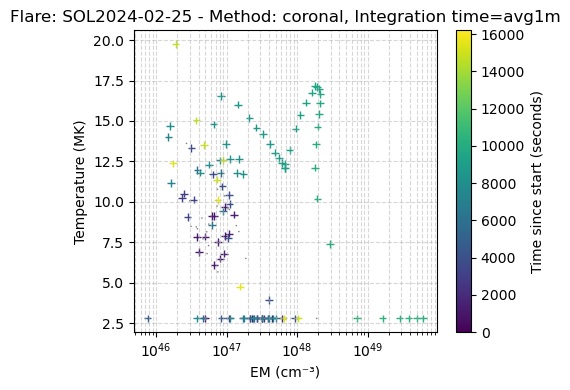

/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


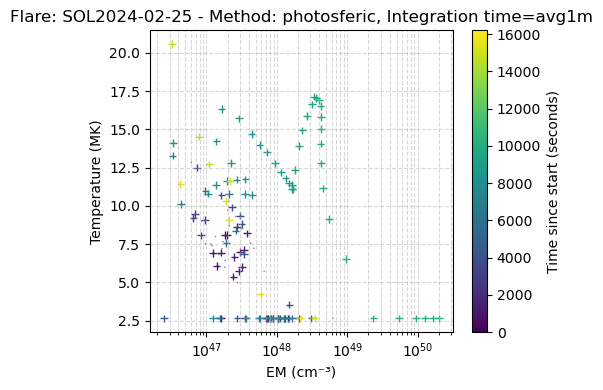

Modelo Coronal:
Temperatura (total): 361
EM (total): 361
Modelo Fotosférico:
Temperatura (total): 361
EM (total): 361
Después del filtro Coronal: 359 359
Después del filtro Fotosférico: 359 359
Modelo Coronal:
T min: 2.811525918516973 T max: 19.751079496164877
EM min: -6.397134363033533e+49 EM max: 6.156326554844997e+49
Modelo Fotosférico:
T min: 2.637235330391021 T max: 20.57262241666709
EM min: -2.0998628736545043e+50 EM max: 2.0208175781510598e+50


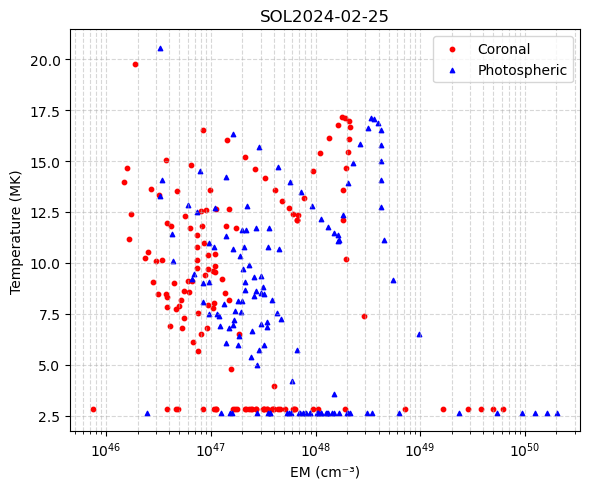

FAI events (Coronal): [Timestamp('2024-02-25 14:41:00'), Timestamp('2024-02-25 14:42:00'), Timestamp('2024-02-25 14:43:00'), Timestamp('2024-02-25 14:45:00'), Timestamp('2024-02-25 14:48:00'), Timestamp('2024-02-25 14:49:00'), Timestamp('2024-02-25 15:16:00'), Timestamp('2024-02-25 15:17:00'), Timestamp('2024-02-25 15:18:00'), Timestamp('2024-02-25 15:19:00'), Timestamp('2024-02-25 15:26:00'), Timestamp('2024-02-25 15:27:00'), Timestamp('2024-02-25 15:28:00'), Timestamp('2024-02-25 15:29:00'), Timestamp('2024-02-25 15:30:00'), Timestamp('2024-02-25 15:31:00'), Timestamp('2024-02-25 16:06:00'), Timestamp('2024-02-25 16:07:00'), Timestamp('2024-02-25 16:08:00'), Timestamp('2024-02-25 16:09:00'), Timestamp('2024-02-25 16:26:00'), Timestamp('2024-02-25 16:27:00'), Timestamp('2024-02-25 16:37:00'), Timestamp('2024-02-25 16:41:00'), Timestamp('2024-02-25 16:42:00'), Timestamp('2024-02-25 16:43:00'), Timestamp('2024-02-25 16:51:00'), Timestamp('2024-02-25 16:52:00'), Timestamp('2024-02-25 16:

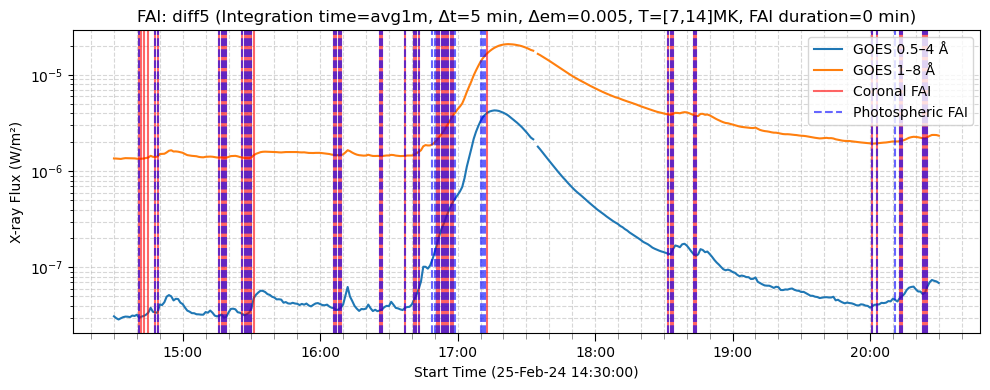

In [9]:
Calculate_all(start_time = start_time,
                  end_time = end_time,
                  flare_start_time = flare_start_time,
                  flare_end_time = flare_end_time,
                  time_colors = time_colors,
                  title = title,
                  resolution="avg1m",
                  file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc",
                  method='diff5',
                  scaling_factor_a=1,
                  scaling_factor_b=1,
                  plot=True,
                  umbral_temp_max = 30,
                  delta_t=5,
                  em_thresh=0.005,
                  Tmin=7,
                  Tmax=14, 
                  fai_dur=0,
                  models_to_plot_fai="both")

### Función completa Method Background = 'min10'  Resolution = 1 min

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  5.01file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-02-25 00:00:00
End Date:			2024-02-25 23:59:00
Center Date:			2024-02-25 11:59:30
Resolution:			59.958 s
Samples per Channel:		1440
Data Range(s):		xrsa           4.27E-06<br>xrsb           1.97E-05<br>xrsa_quality   2.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-02-25 00:00:00  5.740141e-08  0.000002             0             0
2024-02-25 00:01:00  7.020226e-08  0.000002             0             0
2024-02-25 00:02:00  8.091072e-08  0.000002             0             0
2024-02-25 00:03:00  9.033434e-08  0.000002             0             0
2024-02-25 00:04:00  9.776895e-08  0.000002             0             0
...                           ...       ...   

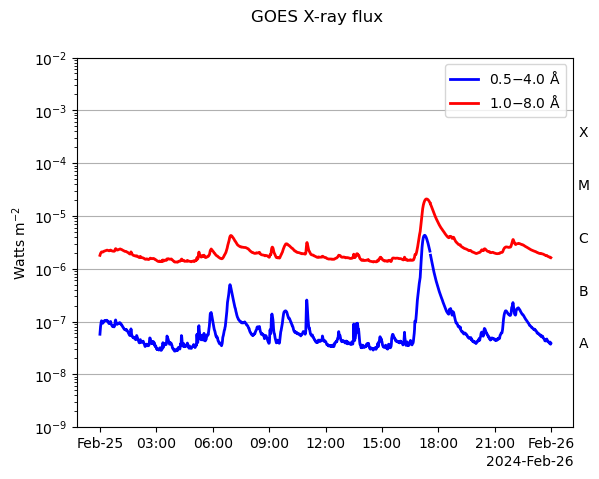

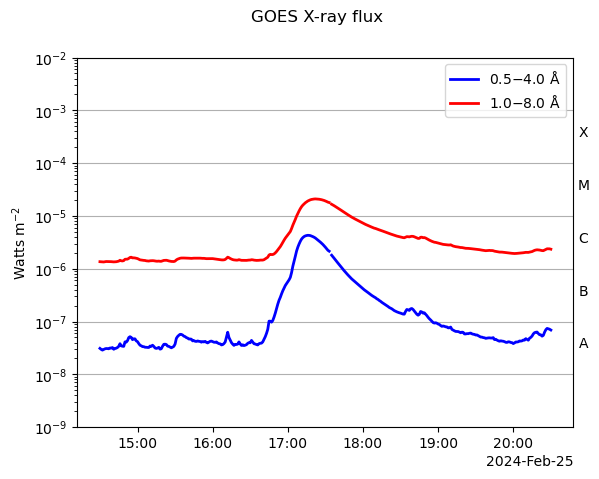

2025-05-30 02:39:11 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 2.873944282555385e-08
valor de flare_start_index: 0


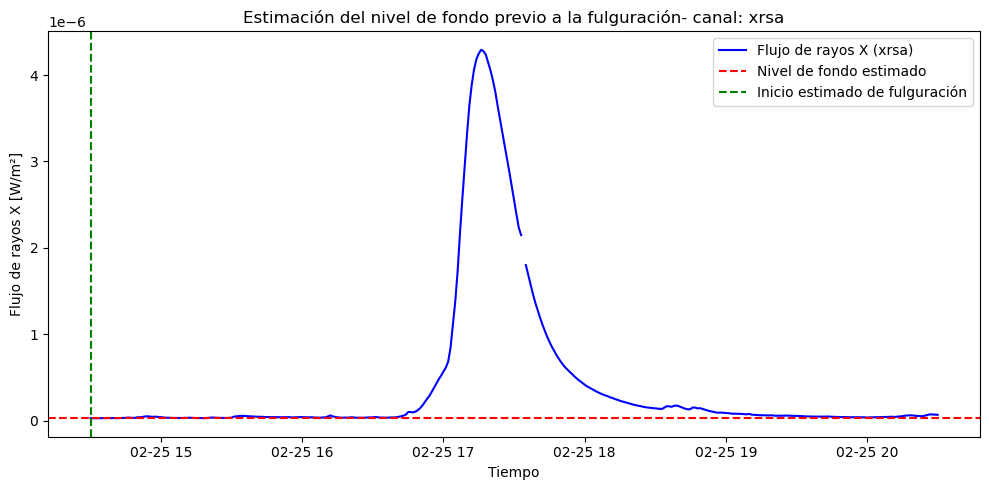

2025-05-30 02:39:11 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 1.342303107776388e-06
valor de flare_start_index: 0


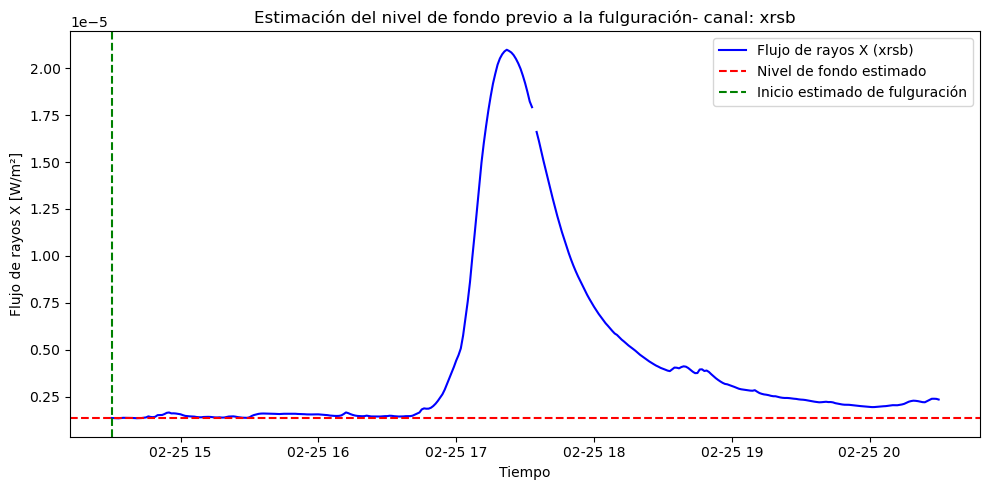

2025-05-30 02:39:11 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:11 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:11 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:12 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
imprimir Copia de los datos del flare (goes_flare) para no modificar los originales
SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		xrsa           4.26E-06<br>xrsb           1.96E-05<br>xrsa_quality   2.00E+00<br>xrsb_quality   2.00E+00
Units:			dimensionless<br>W / m2
                             xrsa      xrsb  xrsa_quality  xrsb_quality
2024-02-25 14:30:00  3.098842e-08  0.000001             0             0
2024-02-25 14:31:00  2.963028e-08  0.000001             0             0
2024-02-25 14:32:00  2.873944e-08  0.000001             0             0
2024-02-25 14:33:00  2.959969e-08  0.000001             0    

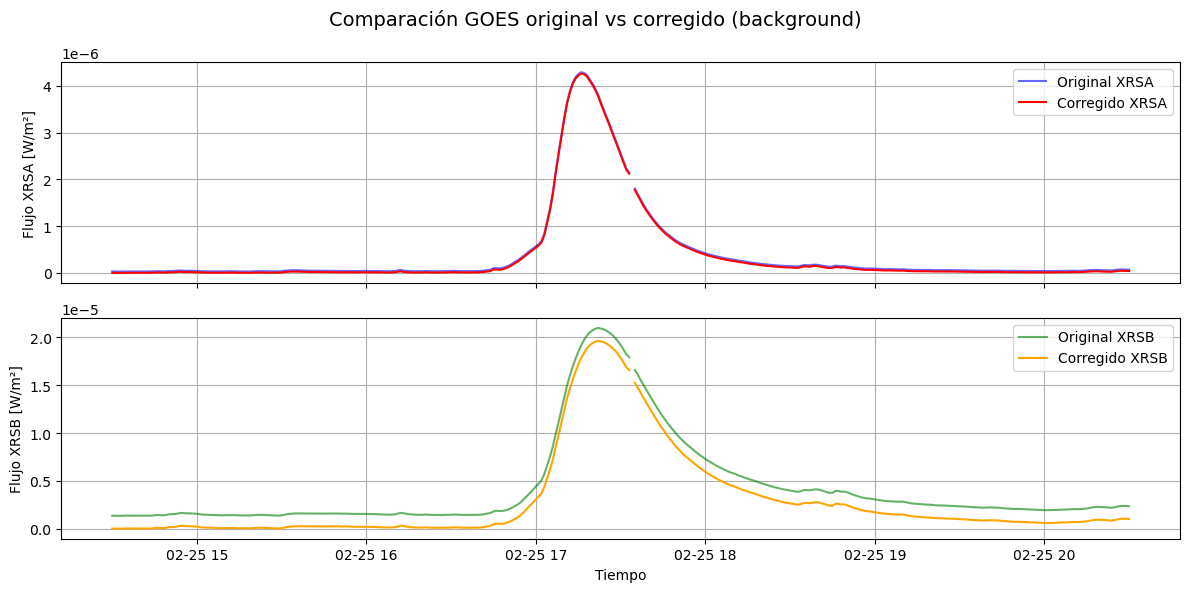

2025-05-30 02:39:12 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.25file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
2025-05-30 02:39:14 - sunpy - WARNING: SunpyUserWarning: No information about primary/secondary detectors in XRSTimeSeries, assuming primary for all


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.28E+01<br>emission_measure   8.03E+48
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.811526      3.510212e+47
2024-02-25 14:31:00     2.811526      2.674346e+47
2024-02-25 14:32:00     2.811526      9.881786e+46
2024-02-25 14:33:00     2.811526      0.000000e+00
2024-02-25 14:34:00     2.811526      3.423376e+47
...                          ...               ...
2024-02-25 20:26:00     6.793738      1.044098e+48
2024-02-25 20:27:00     6.898683      1.068267e+48
2024-02-25 20:28:00     6.801355      1.104233e+48
2024-02-25 20:29:00     6.747340      1.116493e+48
2024-02-25 

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.27file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:30:00
Center Date:			2024-02-25 17:30:00
Resolution:			59.834 s
Samples per Channel:		361
Data Range(s):		temperature        1.26E+01<br>emission_measure   2.07E+49
Units:			MK<br>1 / cm3
                     temperature  emission_measure
2024-02-25 14:30:00     2.637235      1.152229e+48
2024-02-25 14:31:00     2.637235      8.778554e+47
2024-02-25 14:32:00     2.637235      3.243702e+47
2024-02-25 14:33:00     2.637235      0.000000e+00
2024-02-25 14:34:00     2.637235      1.123725e+48
...                          ...               ...
2024-02-25 20:26:00     5.966577      3.612136e+48
2024-02-25 20:27:00     6.061175      3.671069e+48
2024-02-25 20:28:00     5.973435      3.818329e+48
2024-02-25 20:29:00     5.924817      3.873997e+48
2024-0

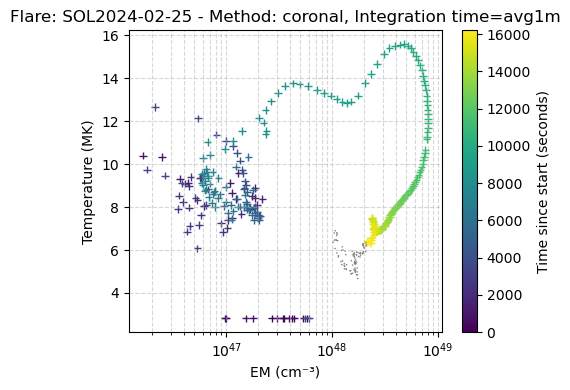

/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


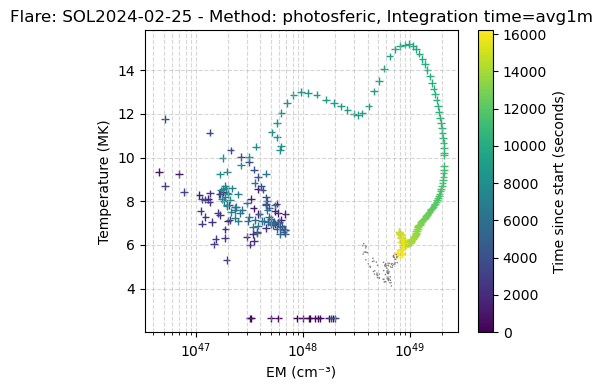

Modelo Coronal:
Temperatura (total): 361
EM (total): 361
Modelo Fotosférico:
Temperatura (total): 361
EM (total): 361
Después del filtro Coronal: 360 360
Después del filtro Fotosférico: 360 360
Modelo Coronal:
T min: 2.811525924575948 T max: 15.600944892017568
EM min: 0.0 EM max: 8.02730174650796e+48
Modelo Fotosférico:
T min: 2.637235335313468 T max: 15.197615626776386
EM min: 0.0 EM max: 2.0706257541665578e+49


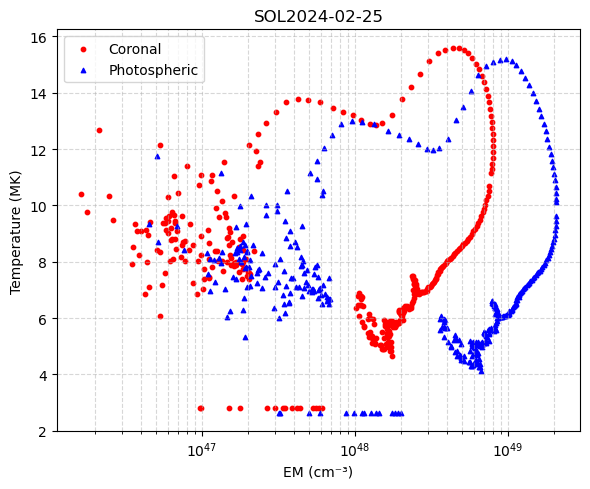

FAI events (Coronal): [Timestamp('2024-02-25 14:45:00'), Timestamp('2024-02-25 14:49:00'), Timestamp('2024-02-25 15:27:00'), Timestamp('2024-02-25 15:31:00'), Timestamp('2024-02-25 15:42:00'), Timestamp('2024-02-25 16:07:00'), Timestamp('2024-02-25 16:39:00'), Timestamp('2024-02-25 16:43:00'), Timestamp('2024-02-25 16:47:00'), Timestamp('2024-02-25 16:51:00'), Timestamp('2024-02-25 16:55:00'), Timestamp('2024-02-25 16:59:00'), Timestamp('2024-02-25 17:15:00'), Timestamp('2024-02-25 17:19:00'), Timestamp('2024-02-25 17:23:00'), Timestamp('2024-02-25 18:35:00')]
FAI events (Photosferic): [Timestamp('2024-02-25 14:44:00'), Timestamp('2024-02-25 14:48:00'), Timestamp('2024-02-25 14:52:00'), Timestamp('2024-02-25 15:16:00'), Timestamp('2024-02-25 15:26:00'), Timestamp('2024-02-25 15:30:00'), Timestamp('2024-02-25 15:34:00'), Timestamp('2024-02-25 15:39:00'), Timestamp('2024-02-25 16:07:00'), Timestamp('2024-02-25 16:37:00'), Timestamp('2024-02-25 16:41:00'), Timestamp('2024-02-25 16:45:00')

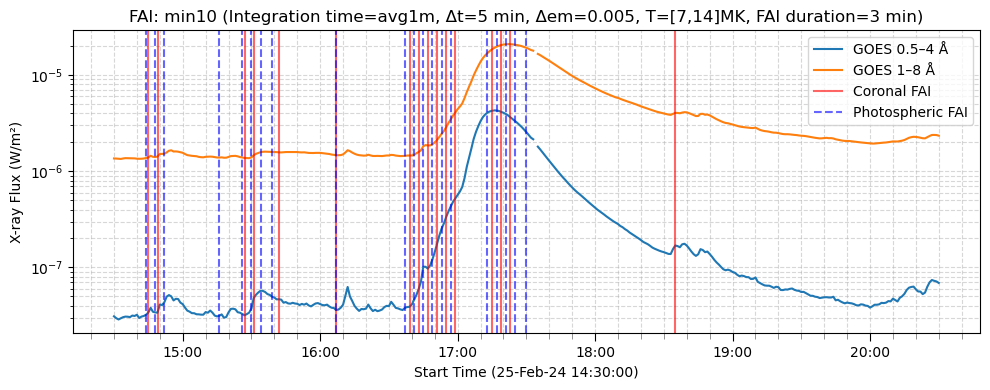

In [10]:
Calculate_all(start_time = start_time,
                  end_time = end_time,
                  flare_start_time = flare_start_time,
                  flare_end_time = flare_end_time,
                  time_colors = time_colors,
                  title = title,
                  resolution="avg1m",
                  file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc",
                  method='min10',
                  scaling_factor_a=1,
                  scaling_factor_b=1,
                  plot=True,
                  umbral_temp_max = 30,
                  delta_t=5,
                  em_thresh=0.005,
                  Tmin=7,
                  Tmax=14, 
                  fai_dur=3,
                  models_to_plot_fai="both")

### Función completa Method Background = 'min10' Resolución 1 seg

Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  2.35file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality<br>xrsa_primary_chan<br>xrsb_primary_chan
Start Date:			2024-02-25 00:00:00
End Date:			2024-02-25 23:59:59
Center Date:			2024-02-25 11:59:59
Resolution:			1.0 s
Samples per Channel:		86400
Data Range(s):		xrsa                4.32E-06<br>xrsb                1.98E-05<br>xrsa_quality        2.56E+02<br>xrsb_quality        2.56E+02<br>xrsa_primary_chan   2.54E+02<br>xrsb_primary_chan   2.54E+02
Units:			dimensionless<br>W / m2
                                    xrsa      xrsb  xrsa_quality  \
2024-02-25 00:00:00.131690  4.795518e-08  0.000002             0   
2024-02-25 00:00:01.131695  5.660037e-08  0.000002             0   
2024-02-25 00:00:02.131692  5.228572e-08  0.000002             0   
2024-02-25 00:00:03.131708  4.797107e-08  0.000002             0   
2024-02-25 00:

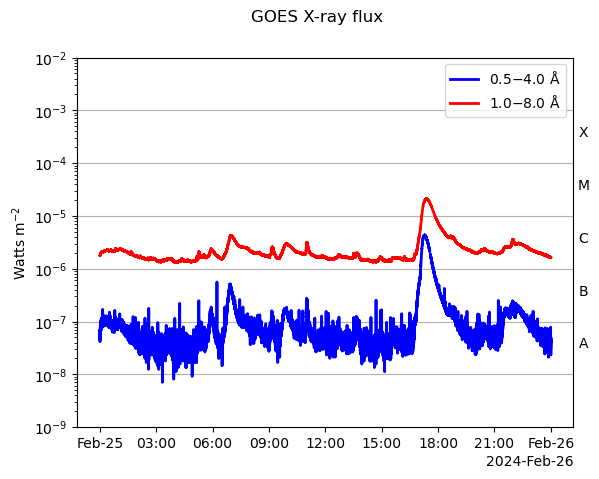

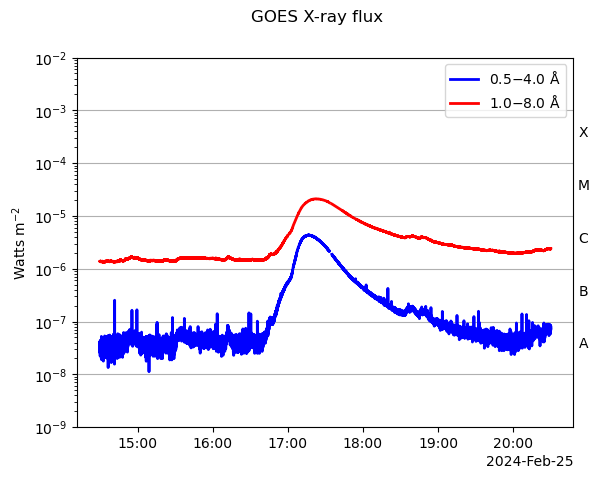

2025-05-30 02:39:46 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 1.3422126521334121e-08
valor de flare_start_index: 0


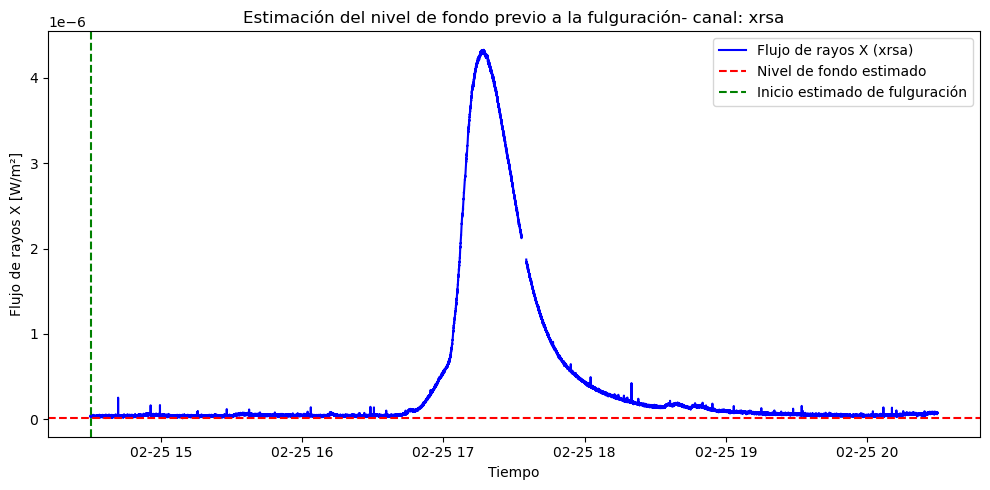

2025-05-30 02:39:46 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 1.3302312709129183e-06
valor de flare_start_index: 0


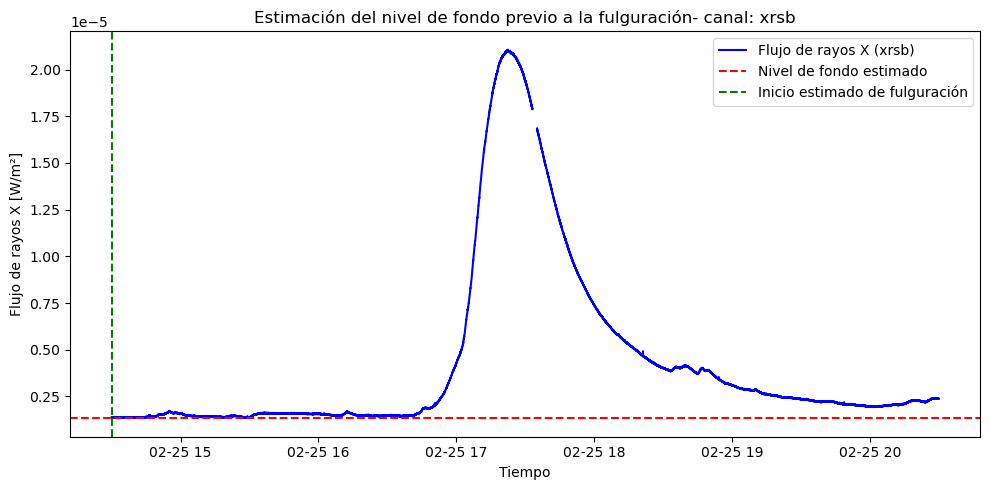

2025-05-30 02:39:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-05-30 02:39:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
imprimir Copia de los datos del flare (goes_flare) para no modificar los originales
SunPy TimeSeries
----------------
Observatory:			GOES-16
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality<br>xrsa_primary_chan<br>xrsb_primary_chan
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:29:59
Center Date:			2024-02-25 17:29:59
Resolution:			1.0 s
Samples per Channel:		21600
Data Range(s):		xrsa                4.32E-06<br>xrsb                1.97E-05<br>xrsa_quality        2.56E+02<br>xrsb_quality        2.56E+02<br>xrsa_primary_chan   2.54E+02<br>xrsb_primary_chan   2.54E+02
Units:			dimensionless<br>W / m2
                                    xrsa      xrsb  xrsa_quality  \
2024-02-25 14:30:00.277785  4.042044e-08  0.000001             0   
2024-02-25 14:30:01.277790  2.961793e-08  0.000001             0   
2024-02-25 14:30:02.

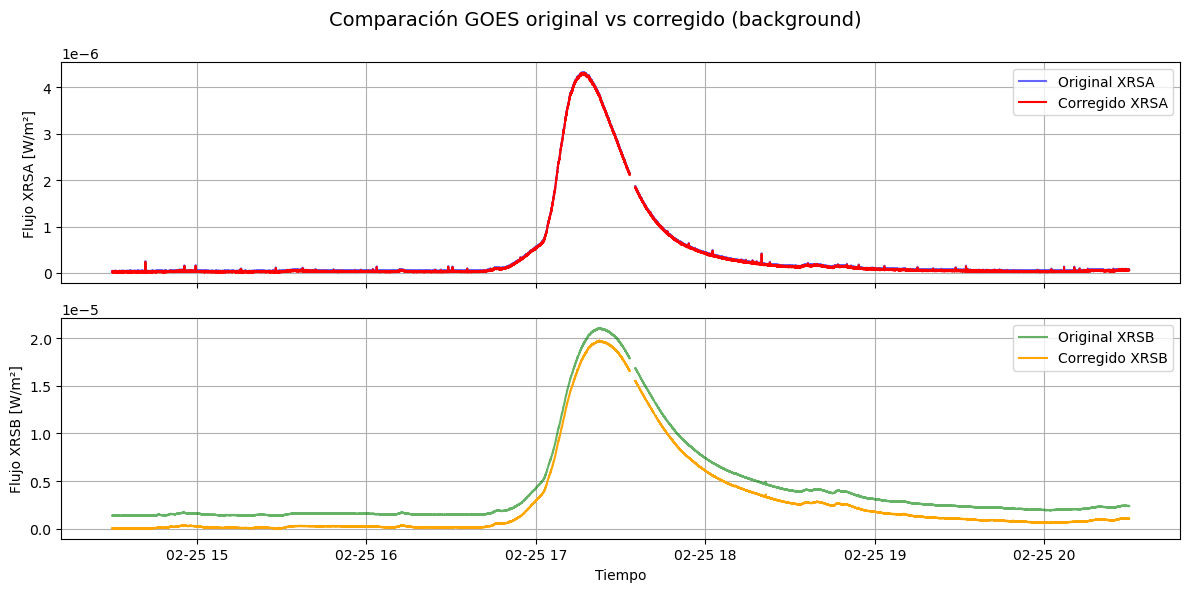

Ahora vamos a calcular la T y EM con el modelo de abundancias:coronal


Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.30file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


se calculó T y EM con el modelo de abundancias:coronal
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:29:59
Center Date:			2024-02-25 17:29:59
Resolution:			1.006 s
Samples per Channel:		21480
Data Range(s):		temperature        1.12E+05<br>emission_measure   8.05E+48
Units:			MK<br>1 / cm3
                            temperature  emission_measure
2024-02-25 14:30:00.277785    35.902035      7.661846e+45
2024-02-25 14:30:01.277790    22.982367      9.058214e+45
2024-02-25 14:30:02.277792    25.168051      1.285932e+46
2024-02-25 14:30:03.277802    13.571276      2.349529e+46
2024-02-25 14:30:04.277796    32.088099      7.445101e+45
...                                 ...               ...
2024-02-25 20:29:55.338783     8.109625      7.812666e+47
2024-02-25 20:29:56.338790     8.087794      7.898264e+47
2024-02-25 20:29:57.338786     7.954118      8.17

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.27file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


se calculó T y EM con el modelo de abundancias:photospheric
SunPy TimeSeries
----------------
Observatory:			Unknown
Instrument:			Unknown
Channel(s):			temperature<br>emission_measure
Start Date:			2024-02-25 14:30:00
End Date:			2024-02-25 20:29:59
Center Date:			2024-02-25 17:29:59
Resolution:			1.006 s
Samples per Channel:		21480
Data Range(s):		temperature        1.12E+04<br>emission_measure   2.09E+49
Units:			MK<br>1 / cm3
                            temperature  emission_measure
2024-02-25 14:30:00.277785    48.064767      9.574862e+45
2024-02-25 14:30:01.277790    25.229127      1.415468e+46
2024-02-25 14:30:02.277792    28.618860      1.901341e+46
2024-02-25 14:30:03.277802    12.780455      5.347779e+46
2024-02-25 14:30:04.277796    40.615876      9.719830e+45
...                                 ...               ...
2024-02-25 20:29:55.338783     7.163583      2.485909e+48
2024-02-25 20:29:56.338790     7.143535      2.516574e+48
2024-02-25 20:29:57.338786     7.020945     

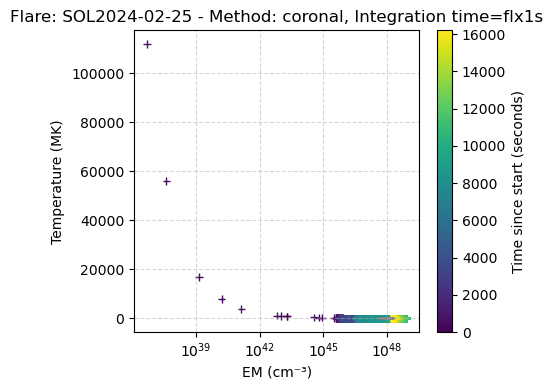

/tmp/ipykernel_51337/648286435.py:906: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


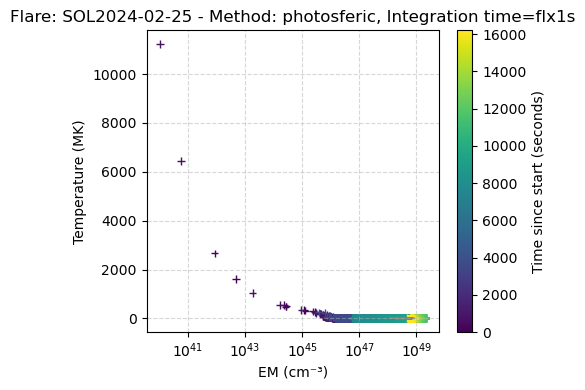

Modelo Coronal:
Temperatura (total): 21480
EM (total): 21480
Modelo Fotosférico:
Temperatura (total): 21480
EM (total): 21480
Después del filtro Coronal: 20307 20307
Después del filtro Fotosférico: 20209 20209
Modelo Coronal:
T min: 2.811525924575948 T max: 29.930511199262423
EM min: 0.0 EM max: 8.054783821736142e+48
Modelo Fotosférico:
T min: 2.637235335313468 T max: 29.732396597331196
EM min: 0.0 EM max: 2.0865540465876948e+49


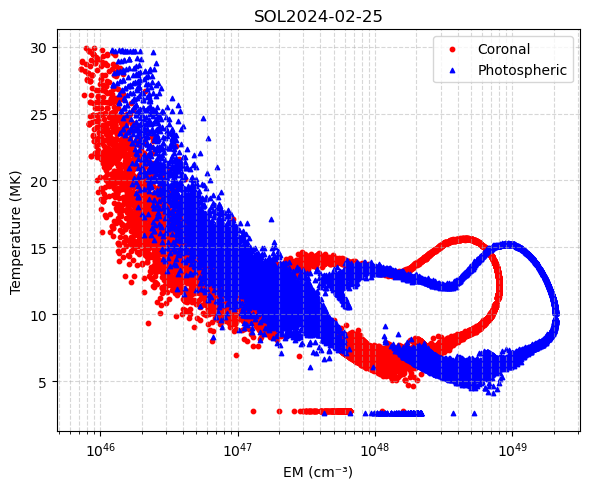

FAI events (Coronal): [Timestamp('2024-02-25 14:45:00'), Timestamp('2024-02-25 14:49:00'), Timestamp('2024-02-25 15:27:00'), Timestamp('2024-02-25 15:31:00'), Timestamp('2024-02-25 16:07:00'), Timestamp('2024-02-25 16:38:00'), Timestamp('2024-02-25 16:42:00'), Timestamp('2024-02-25 16:46:00'), Timestamp('2024-02-25 16:50:00'), Timestamp('2024-02-25 16:54:00'), Timestamp('2024-02-25 16:58:00'), Timestamp('2024-02-25 17:15:00'), Timestamp('2024-02-25 17:19:00'), Timestamp('2024-02-25 17:23:00'), Timestamp('2024-02-25 18:35:00'), Timestamp('2024-02-25 18:45:00'), Timestamp('2024-02-25 20:04:00'), Timestamp('2024-02-25 20:13:00'), Timestamp('2024-02-25 20:17:00')]
FAI events (Photosferic): [Timestamp('2024-02-25 14:44:00'), Timestamp('2024-02-25 14:48:00'), Timestamp('2024-02-25 14:52:00'), Timestamp('2024-02-25 15:16:00'), Timestamp('2024-02-25 15:27:00'), Timestamp('2024-02-25 15:31:00'), Timestamp('2024-02-25 15:42:00'), Timestamp('2024-02-25 16:06:00'), Timestamp('2024-02-25 16:37:00')

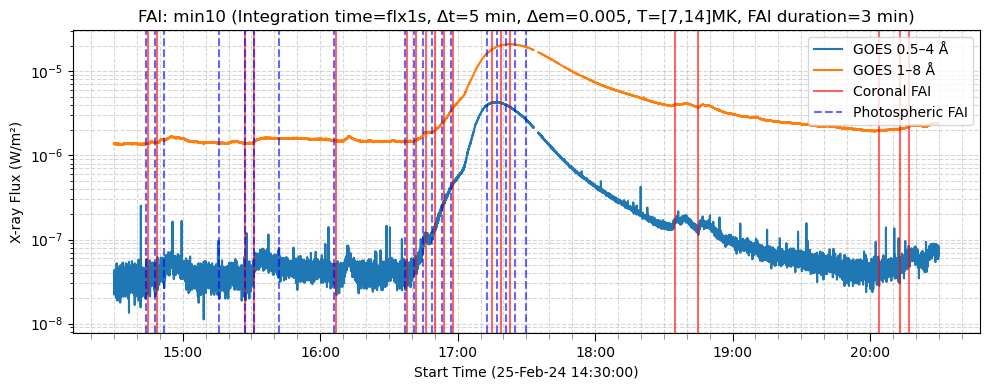

In [11]:
Calculate_all(start_time = start_time,
                  end_time = end_time,
                  flare_start_time = flare_start_time,
                  flare_end_time = flare_end_time,
                  time_colors = time_colors,
                  title = title,
                  resolution="flx1s", # "flx1s" o "avg1m"
                  file_path = "/home/paula/Documentos/UN-Astronomy/Tesis/25-03_FAI/Bibliografía/sci_xrsf-l2-bkd1d_g16_s20170207_e20250314_v2-2-0.nc",
                  method='min10',
                  scaling_factor_a=1,
                  scaling_factor_b=1,
                  plot=True,
                  umbral_temp_max = 30,
                  delta_t=5,
                  em_thresh=0.005,
                  Tmin=7,
                  Tmax=14, 
                  fai_dur=3,
                  models_to_plot_fai="both")